# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime

from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

from boruta import BorutaPy
import xgboost as xgb

## 0.1. Helper Functions

In [105]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1)) :
        
        if verbose:
            print(f'\nKFold Number: {k}')
        
        # statart and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance og each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
            'Model Name': model_name,
            'MAR CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
            'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
            'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
        }, index=[0])

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse
                        }, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0] # resultado do teste chi2 baseado no pearson
    chi2corr = max( 0, chi2 - (k-1) *(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)



In [12]:
df1.sample(5).T

,655125,176491,493610,32997,132053
store,291,322,451,663,484
day_of_week,4,1,2,4,6
date,2013-11-21 00:00:00,2015-02-23 00:00:00,2014-04-15 00:00:00,2015-07-02 00:00:00,2015-04-04 00:00:00
sales,11164,4320,7380,5887,14304
customers,1113,499,573,772,1300
open,1,1,1,1,1
promo,1,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,d,a,a,a,a


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std (desvio padrão), min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attibutes','min','max','range','mean','median','std','skew','kurtosis']

In [17]:
m

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_2829/1604121253.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['customers'])


<AxesSubplot: xlabel='customers', ylabel='Density'>

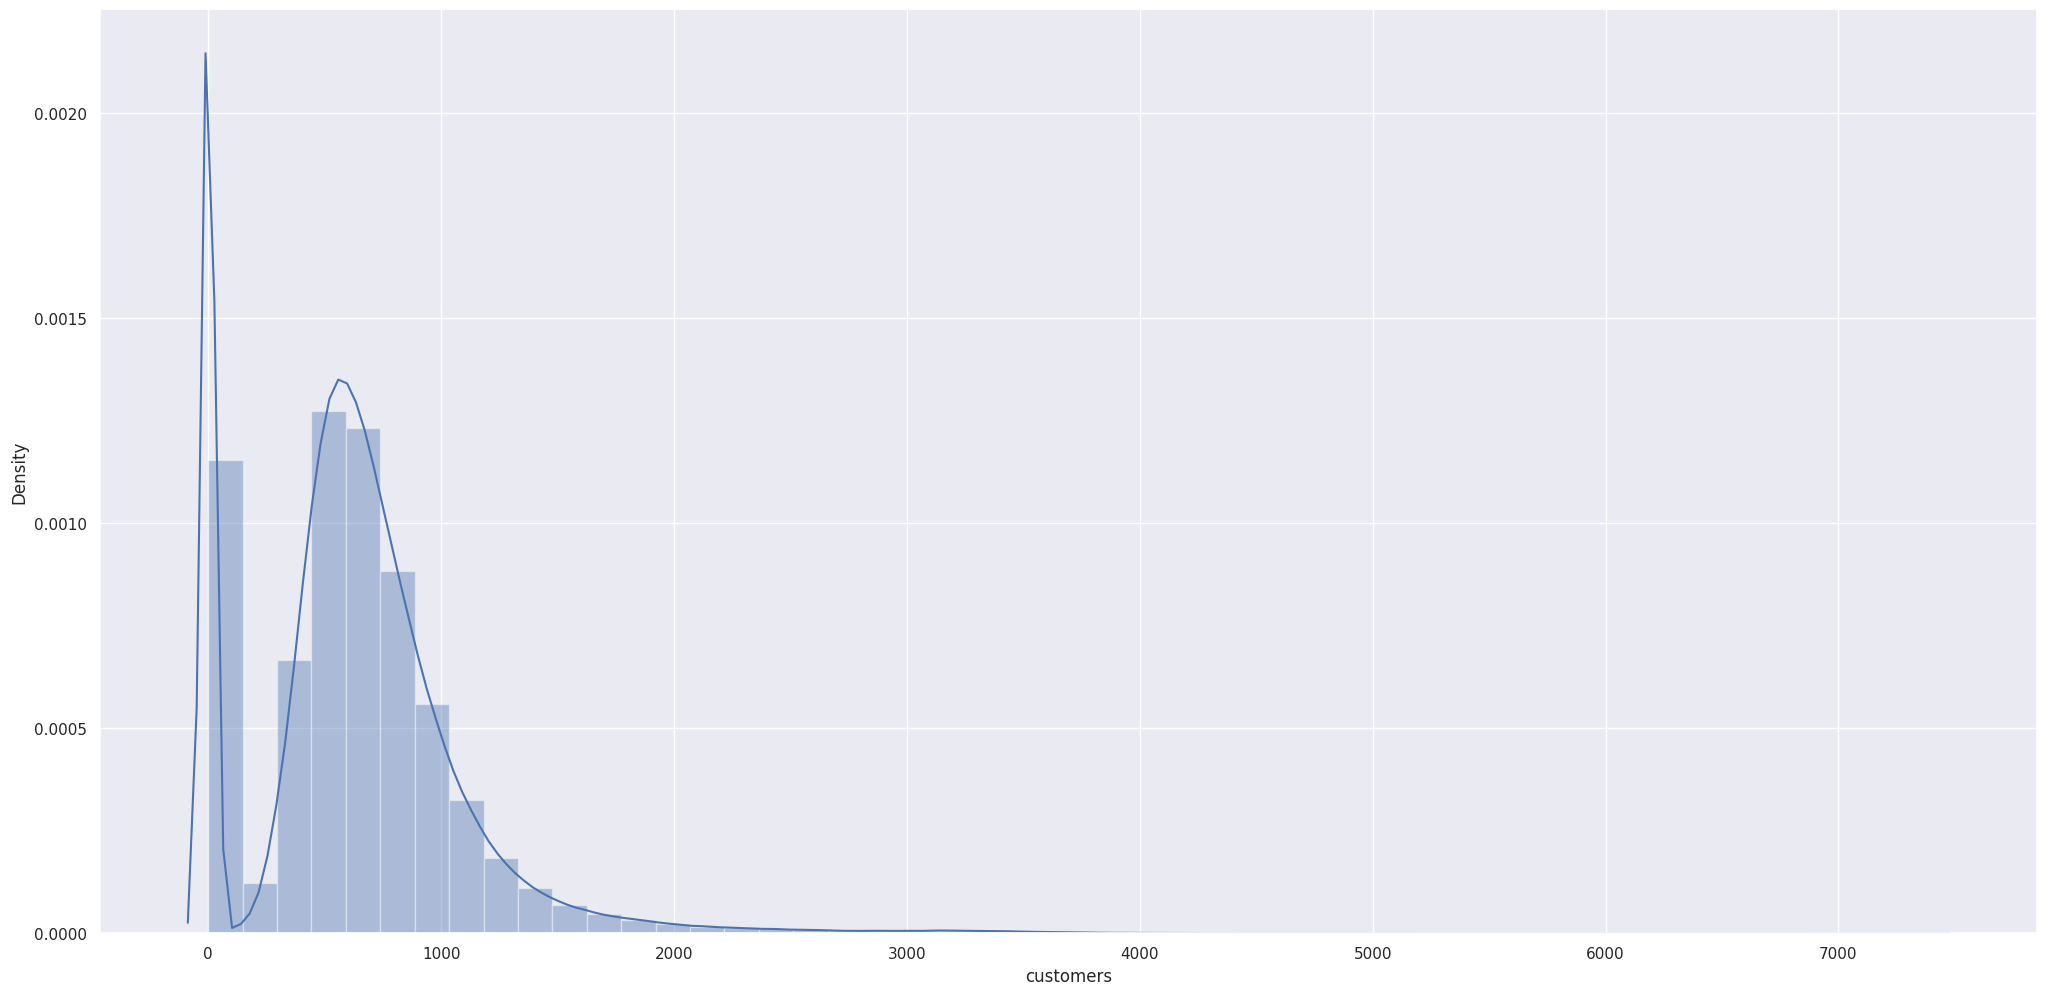

In [18]:
sns.distplot(df1['customers'])

### 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

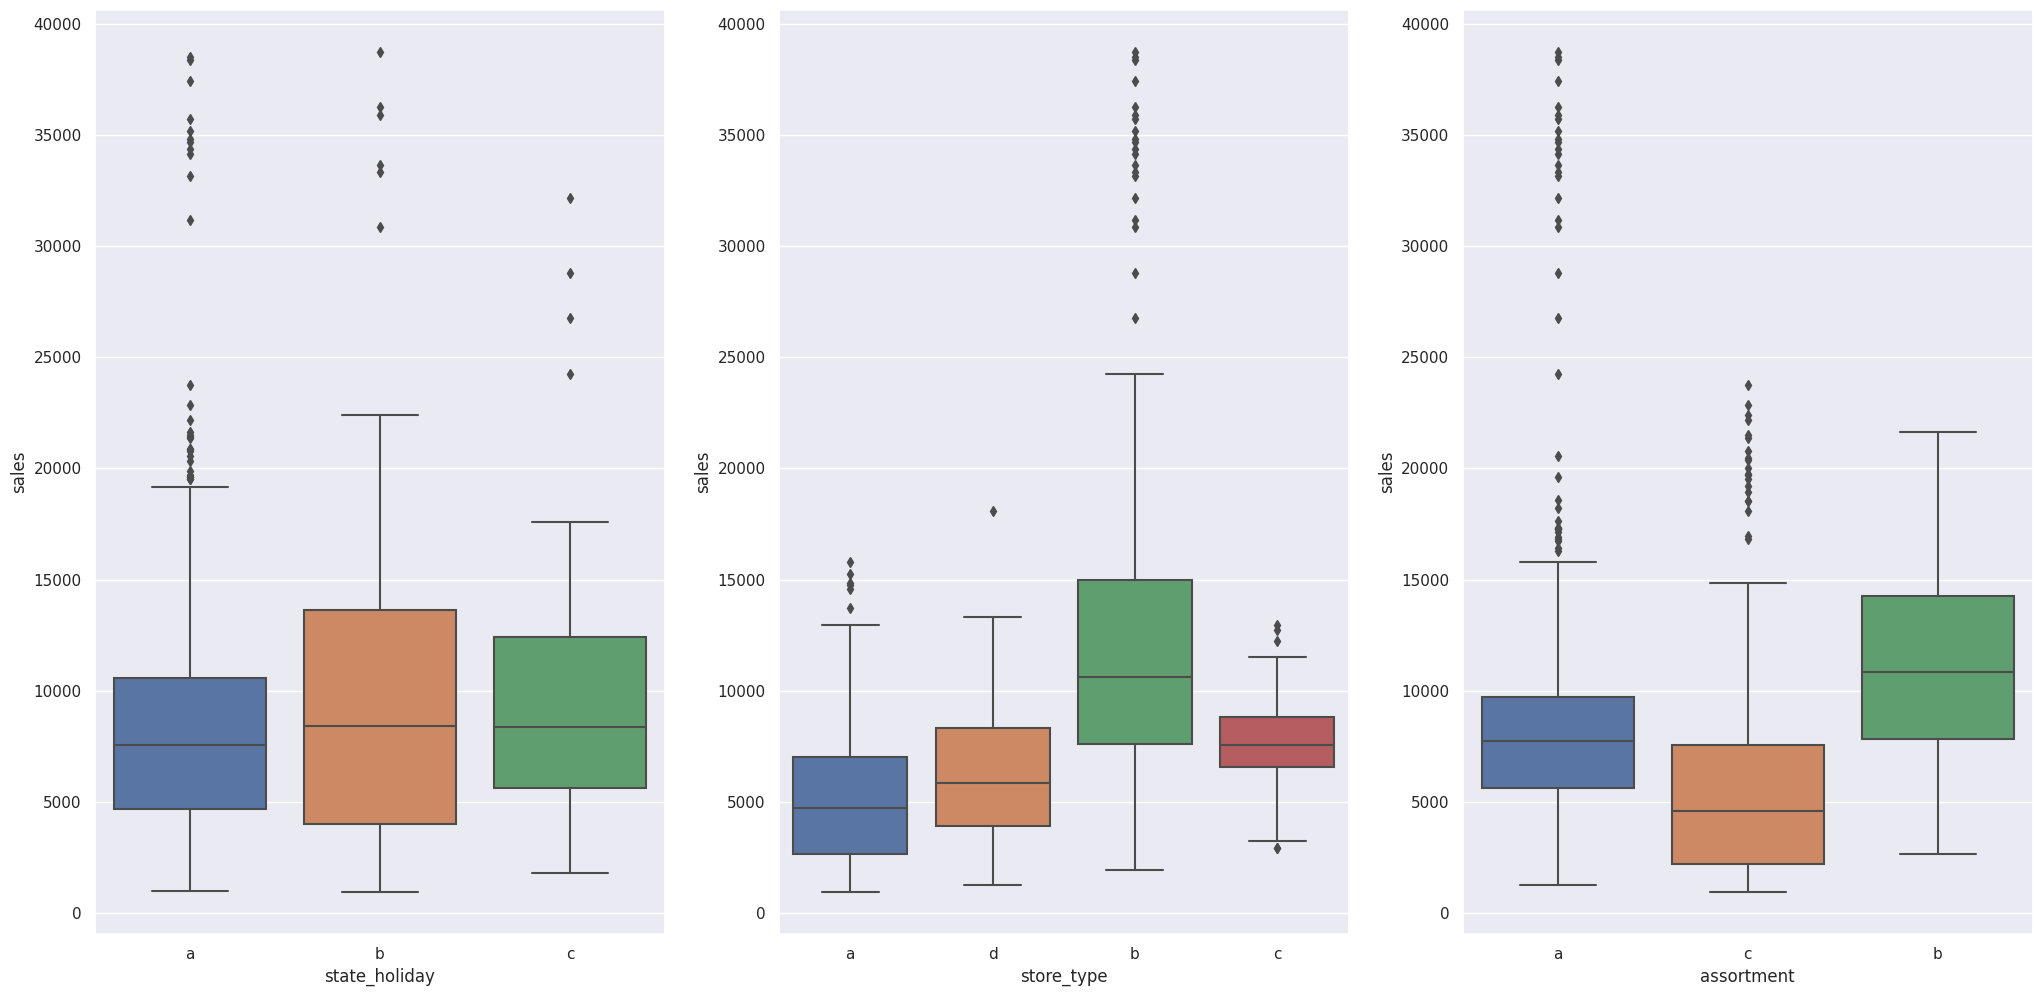

In [20]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

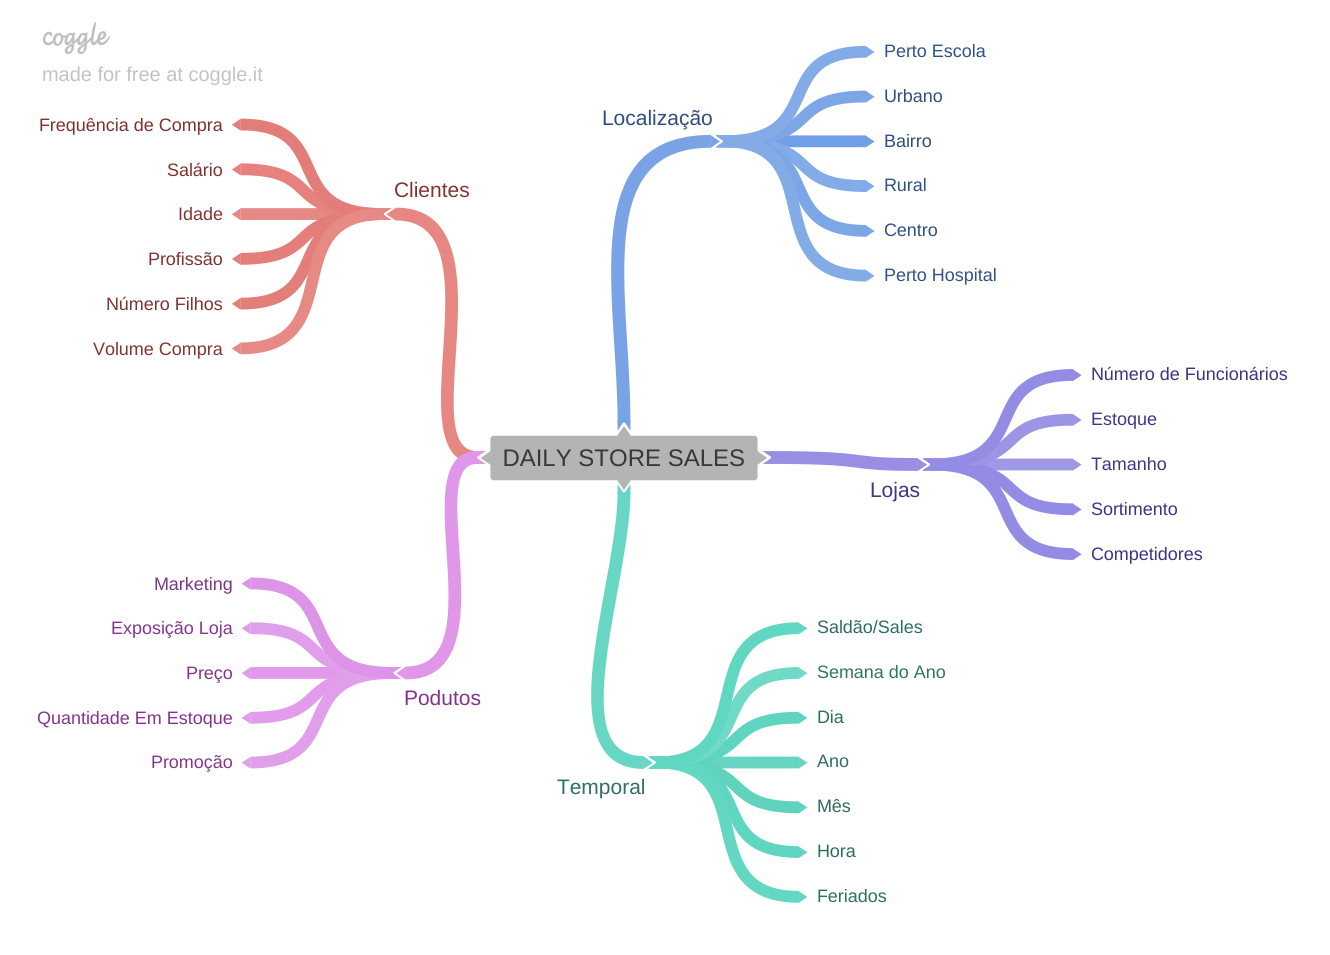

In [22]:
Image('img/MindMapHypothesis.png')

## 2.2 Criação das Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [24]:
df2.sample(5).T

,939888,623913,428561,968480,933260
store,729,299,72,331,791
day_of_week,1,4,4,3,7
date,2013-03-11 00:00:00,2013-12-19 00:00:00,2014-06-12 00:00:00,2013-02-13 00:00:00,2013-03-17 00:00:00
sales,8754,6760,3712,6344,0
customers,975,614,438,877,0
open,1,1,1,1,0
promo,0,1,0,0,0
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,1,0,0
store_type,c,d,a,a,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extend,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] # open: loja fechada não têm vendas / sales: loja sem vendas
 

## 3.2 Seleção das Colunas

In [28]:
cols_drop = ['customers','open','promo_interval', 'month_map'] # customers: no momento da predição, não saberemos qual a quantidade de clientes
df3 = df3.drop(cols_drop, axis=1)

# 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS - EDA

In [29]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Reponse Variable

/tmp/ipykernel_2829/3589390104.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'], bins=25)


<AxesSubplot: xlabel='sales', ylabel='Density'>

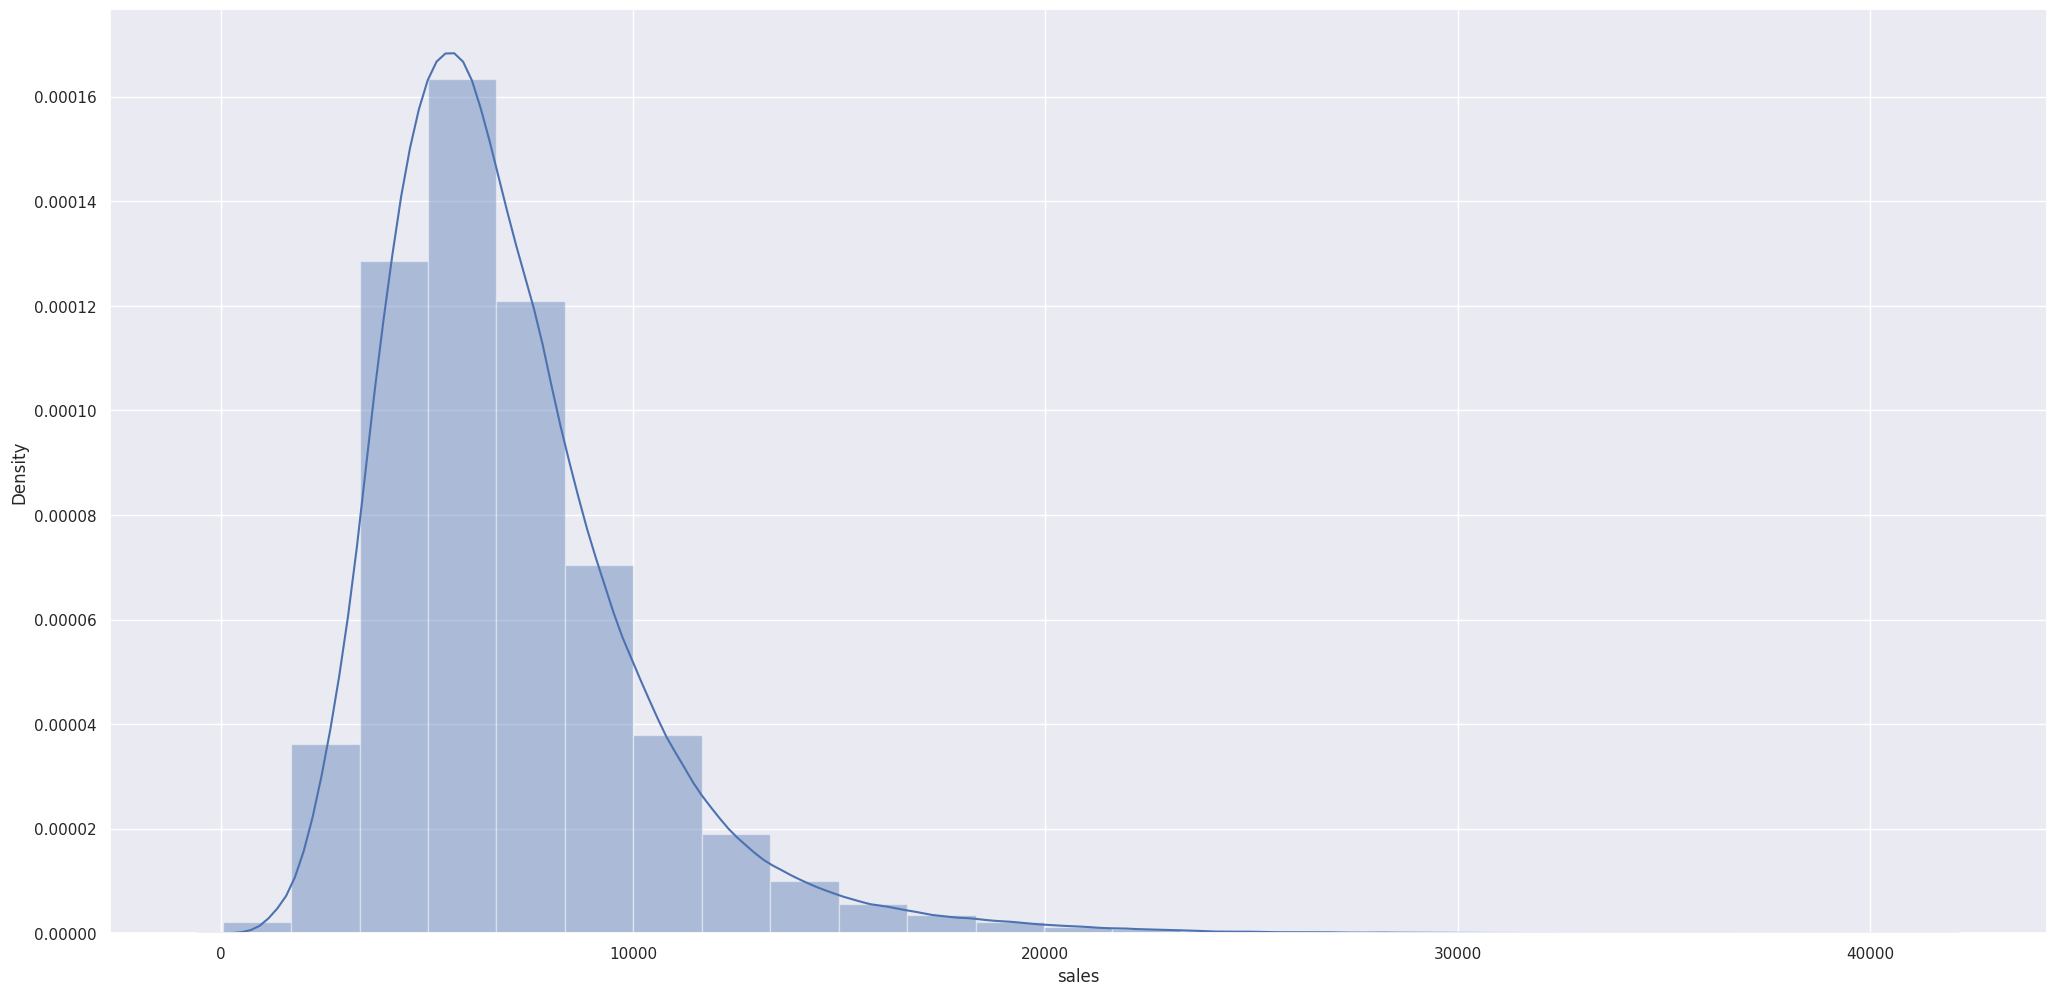

In [30]:
sns.distplot(df4['sales'], bins=25)
# s.distplot(np.log1p(df4['sales'])) # np.log1p transforma os dados em uma distribuição normal

### 4.1.2 Numerical Variable

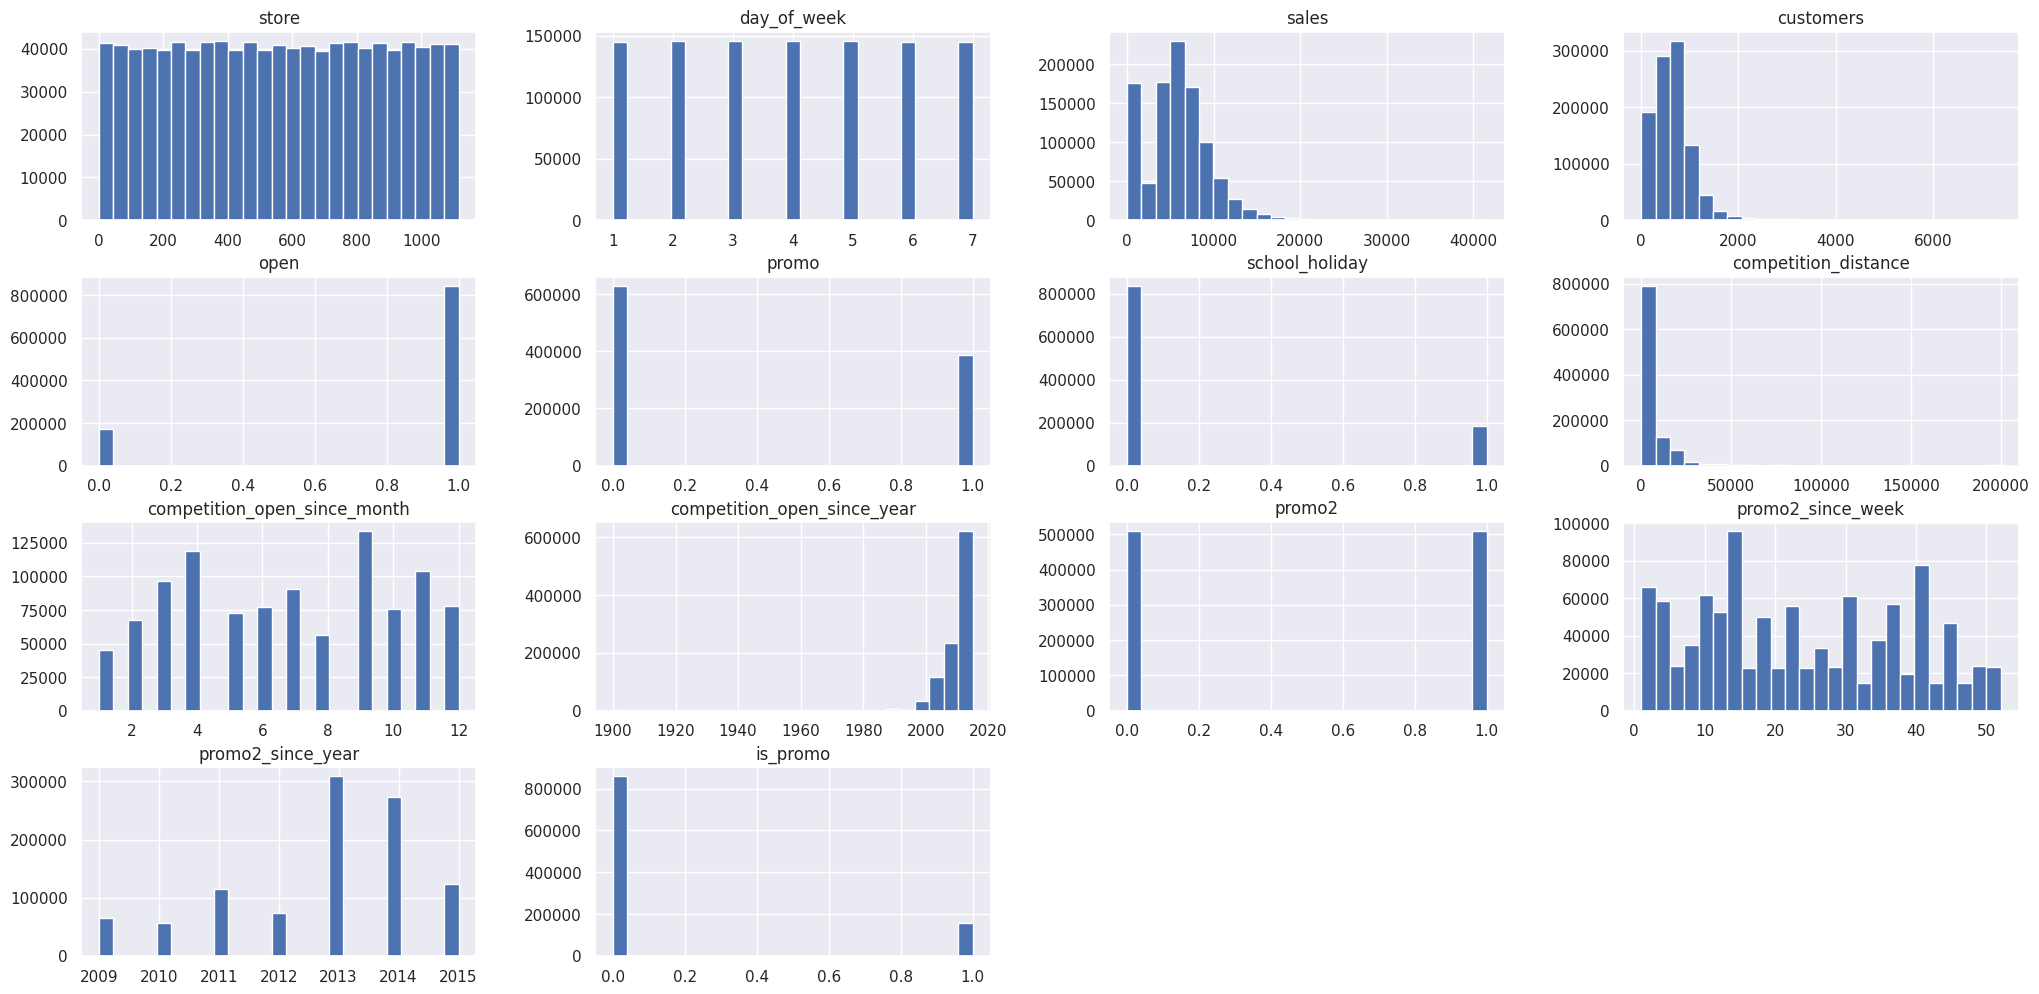

In [31]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [33]:
df4['assortment'].drop_duplicates()

0       basic
3      extend
258     extra
Name: assortment, dtype: object

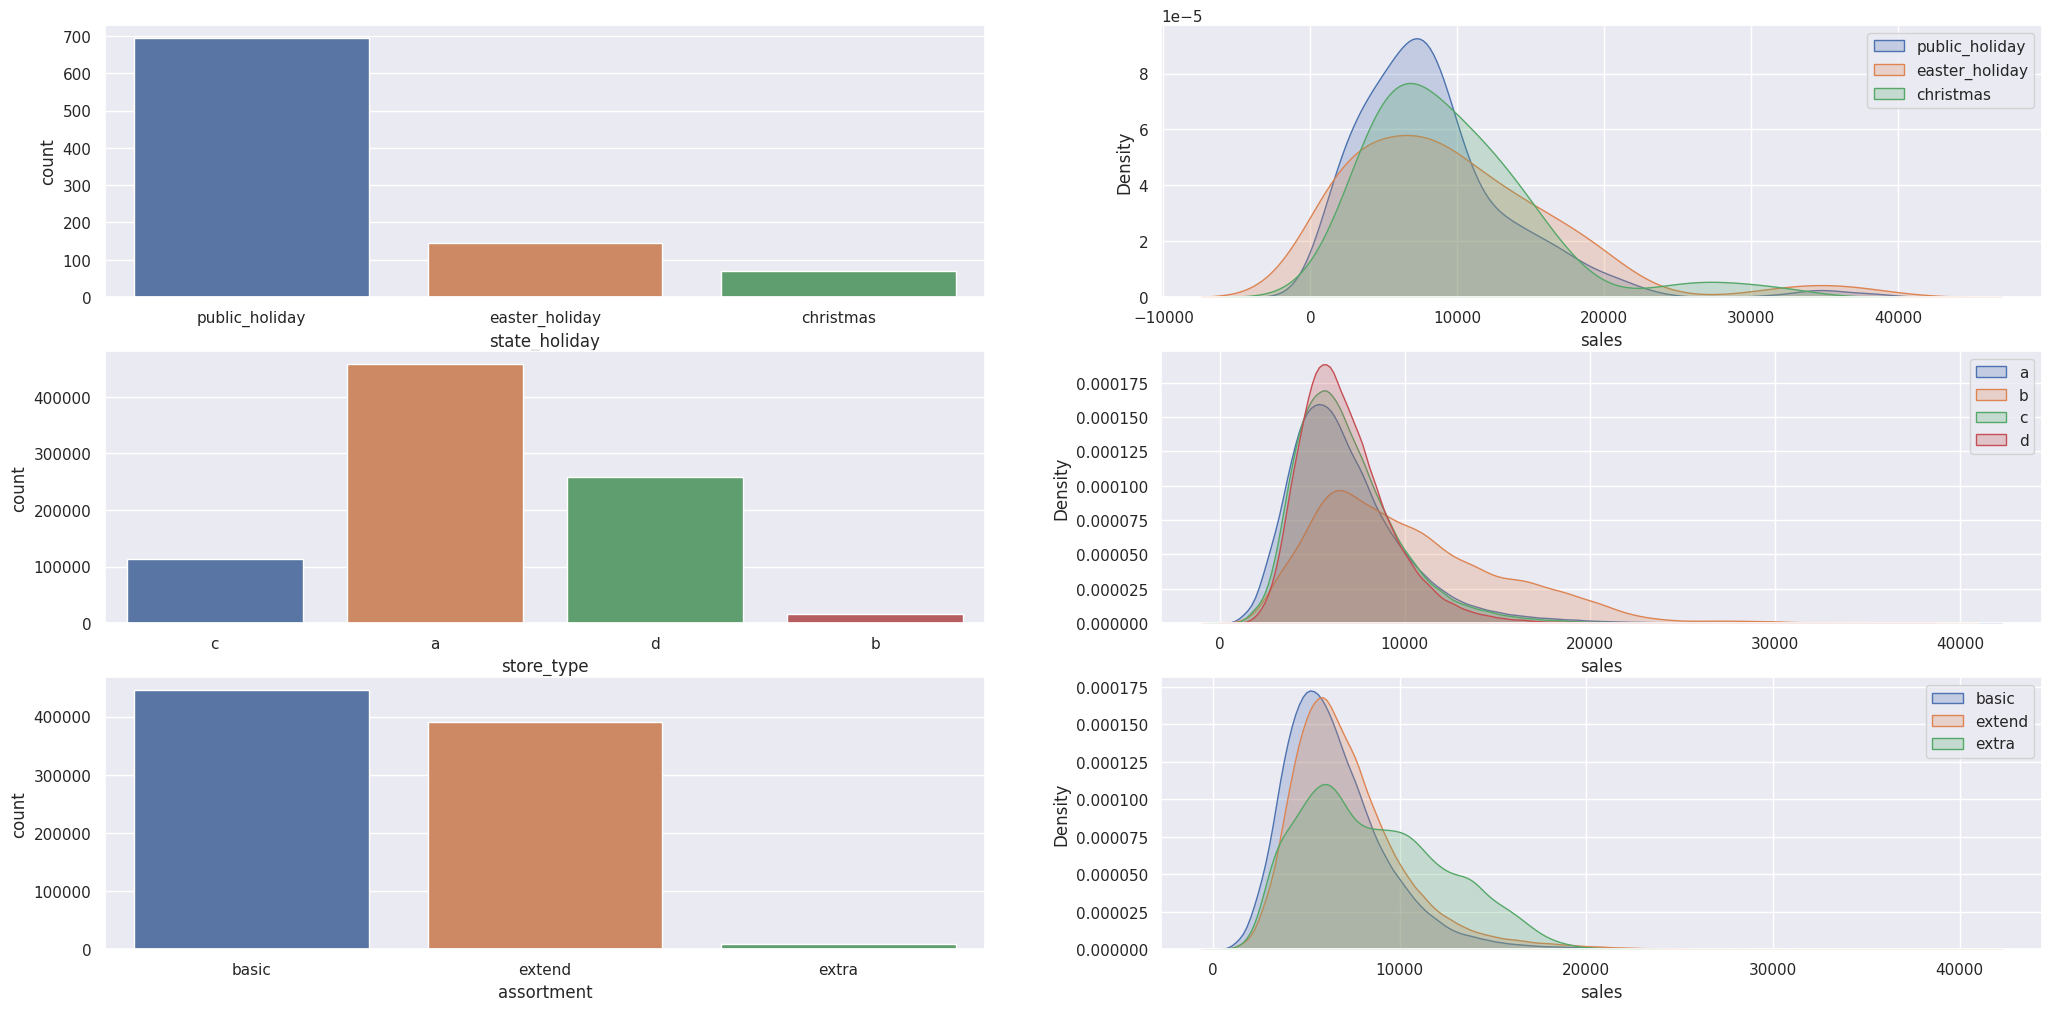

In [34]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill = True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill = True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill = True)
plt.legend()

## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSE** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot: xlabel='year_week'>

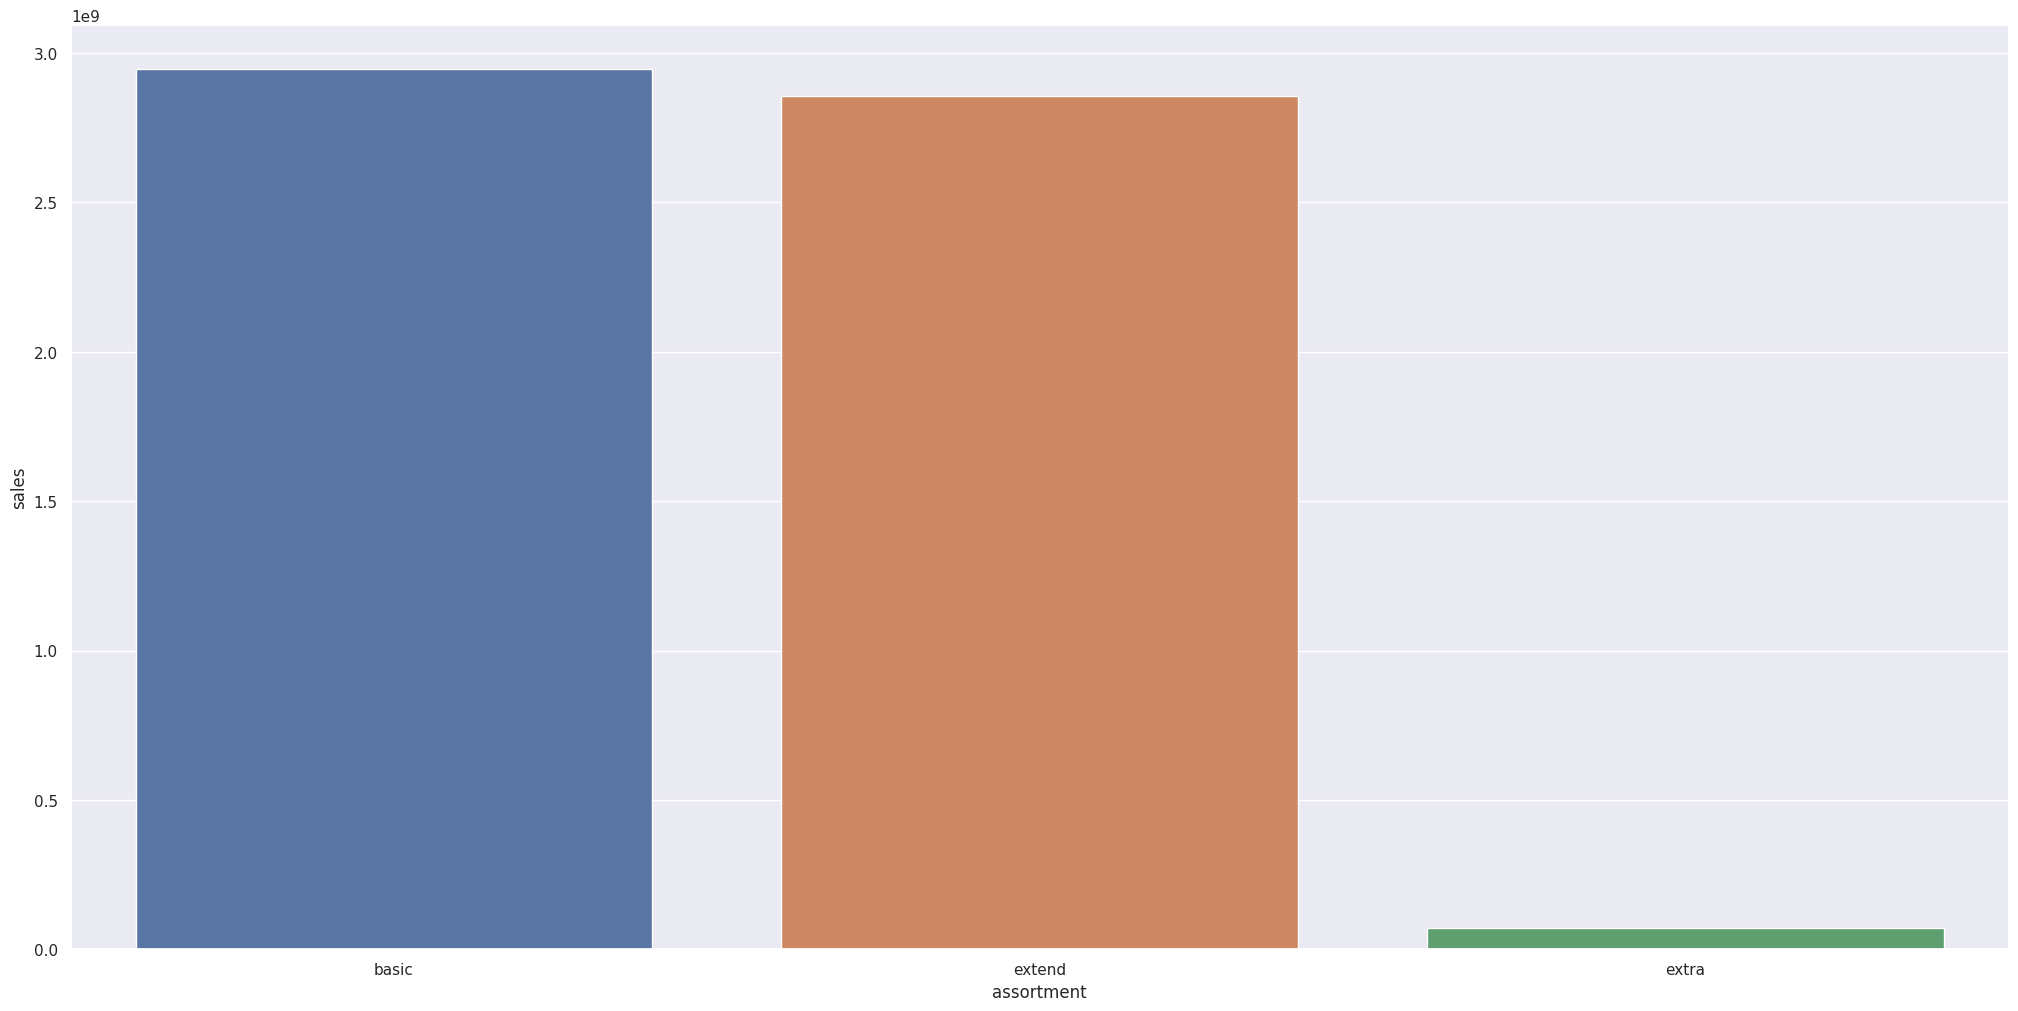

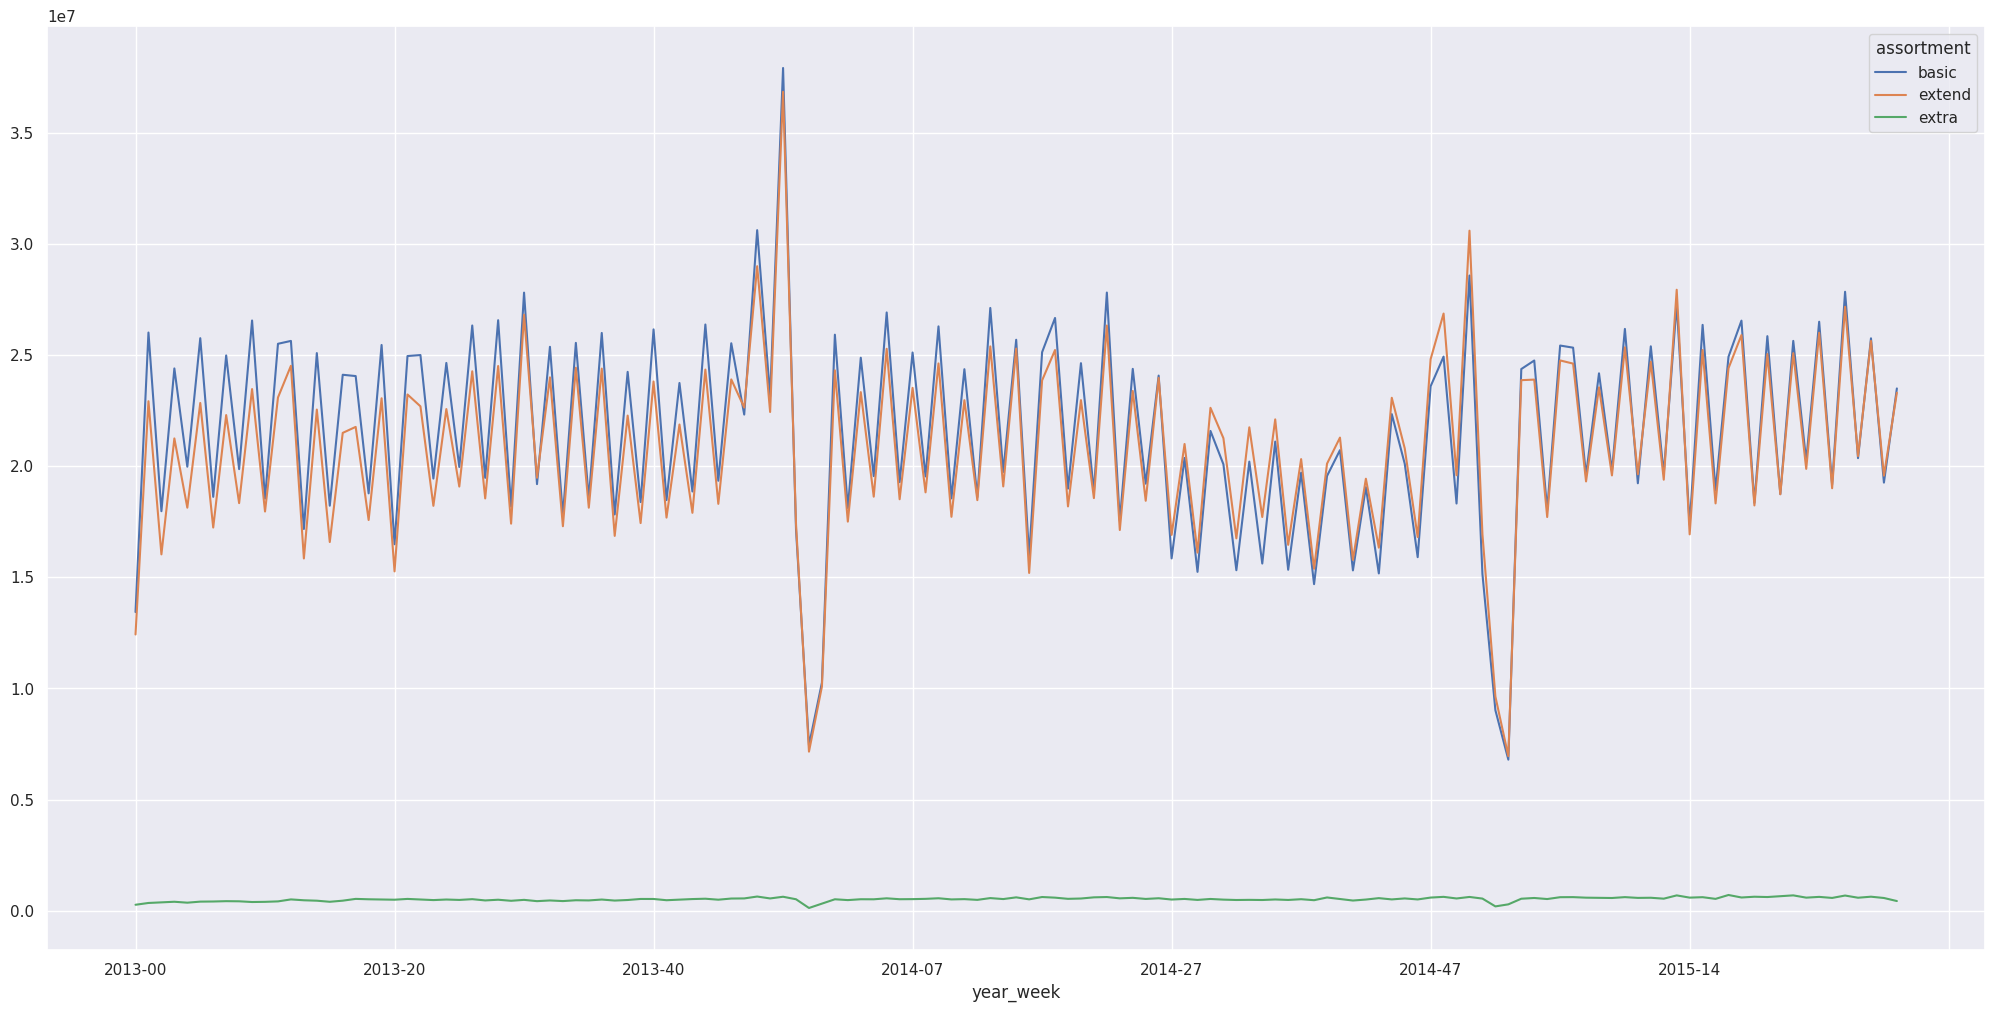

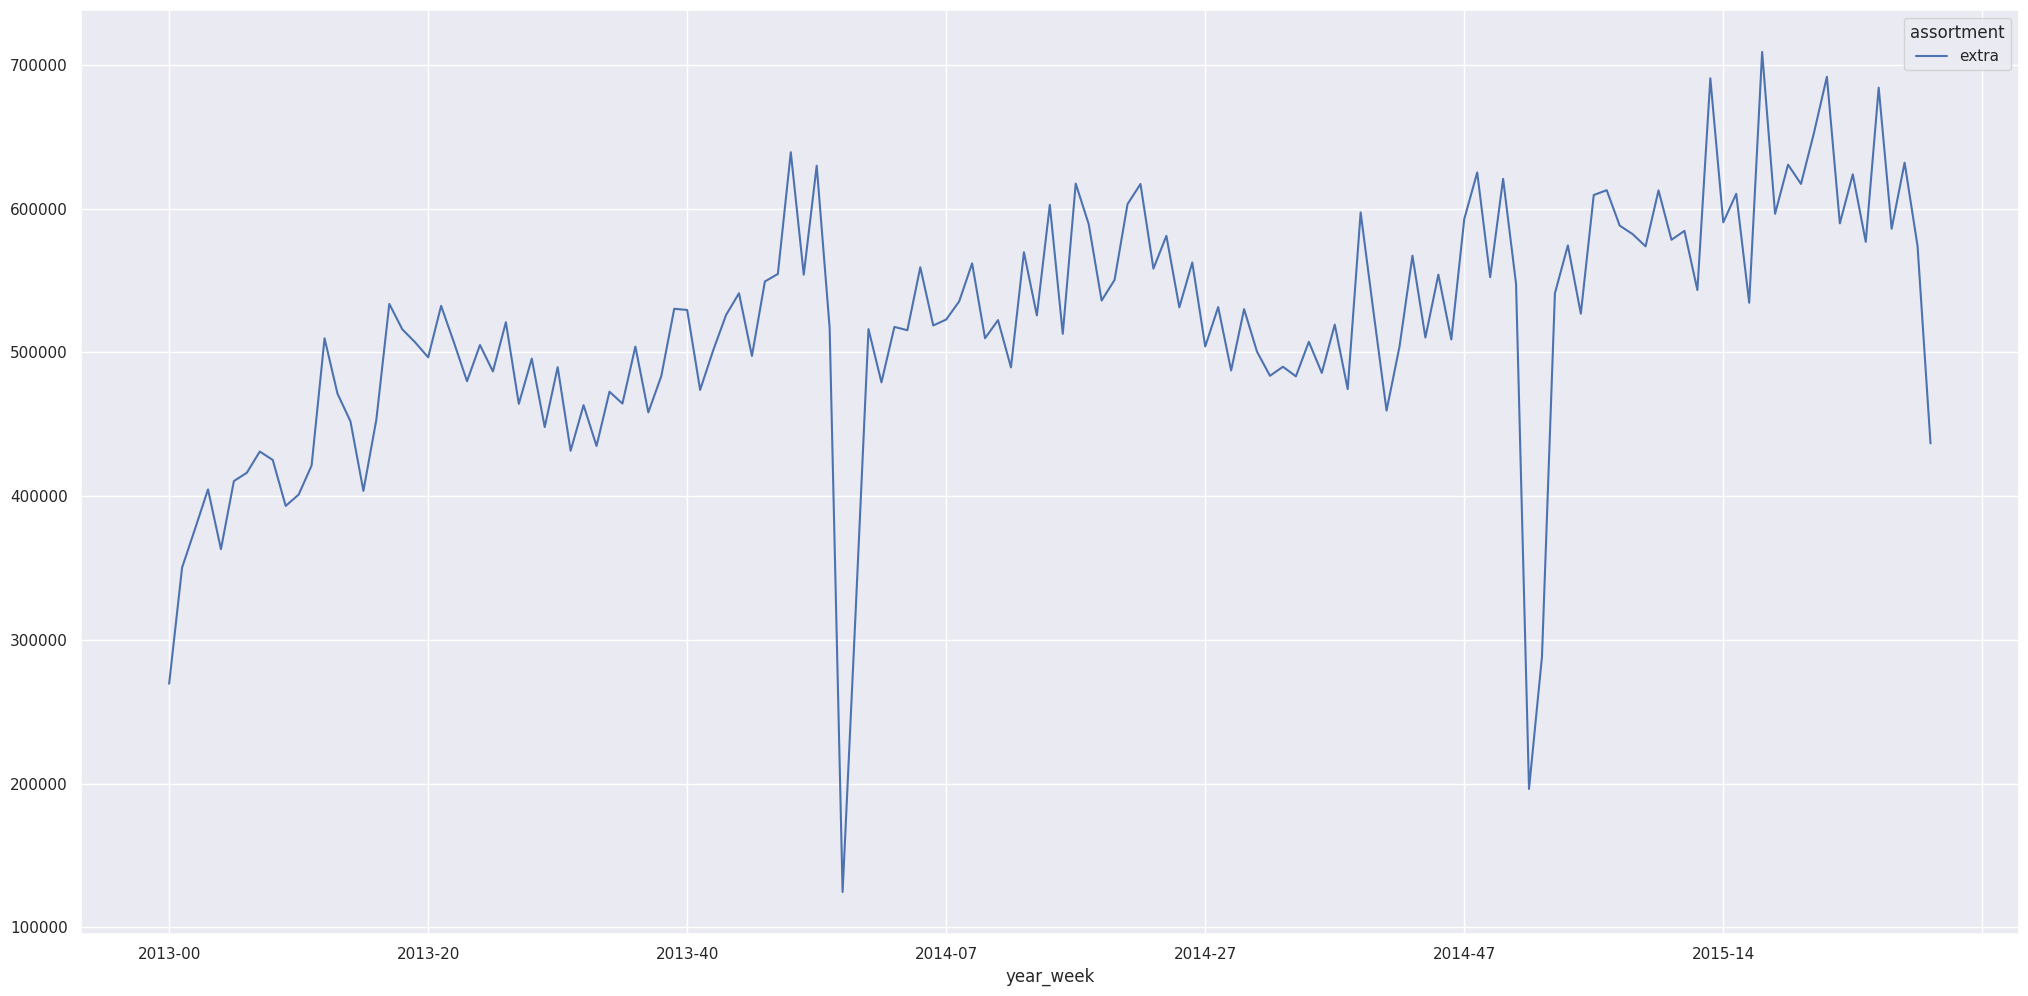

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

In [36]:
aux3.head()

,year_week,assortment,sales
2,2013-00,extra,269404
5,2013-01,extra,350279
8,2013-02,extra,377207
11,2013-03,extra,404662
14,2013-04,extra,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSE** Lojas com competidores MAIS PRÓXIMOS vendem MAIS

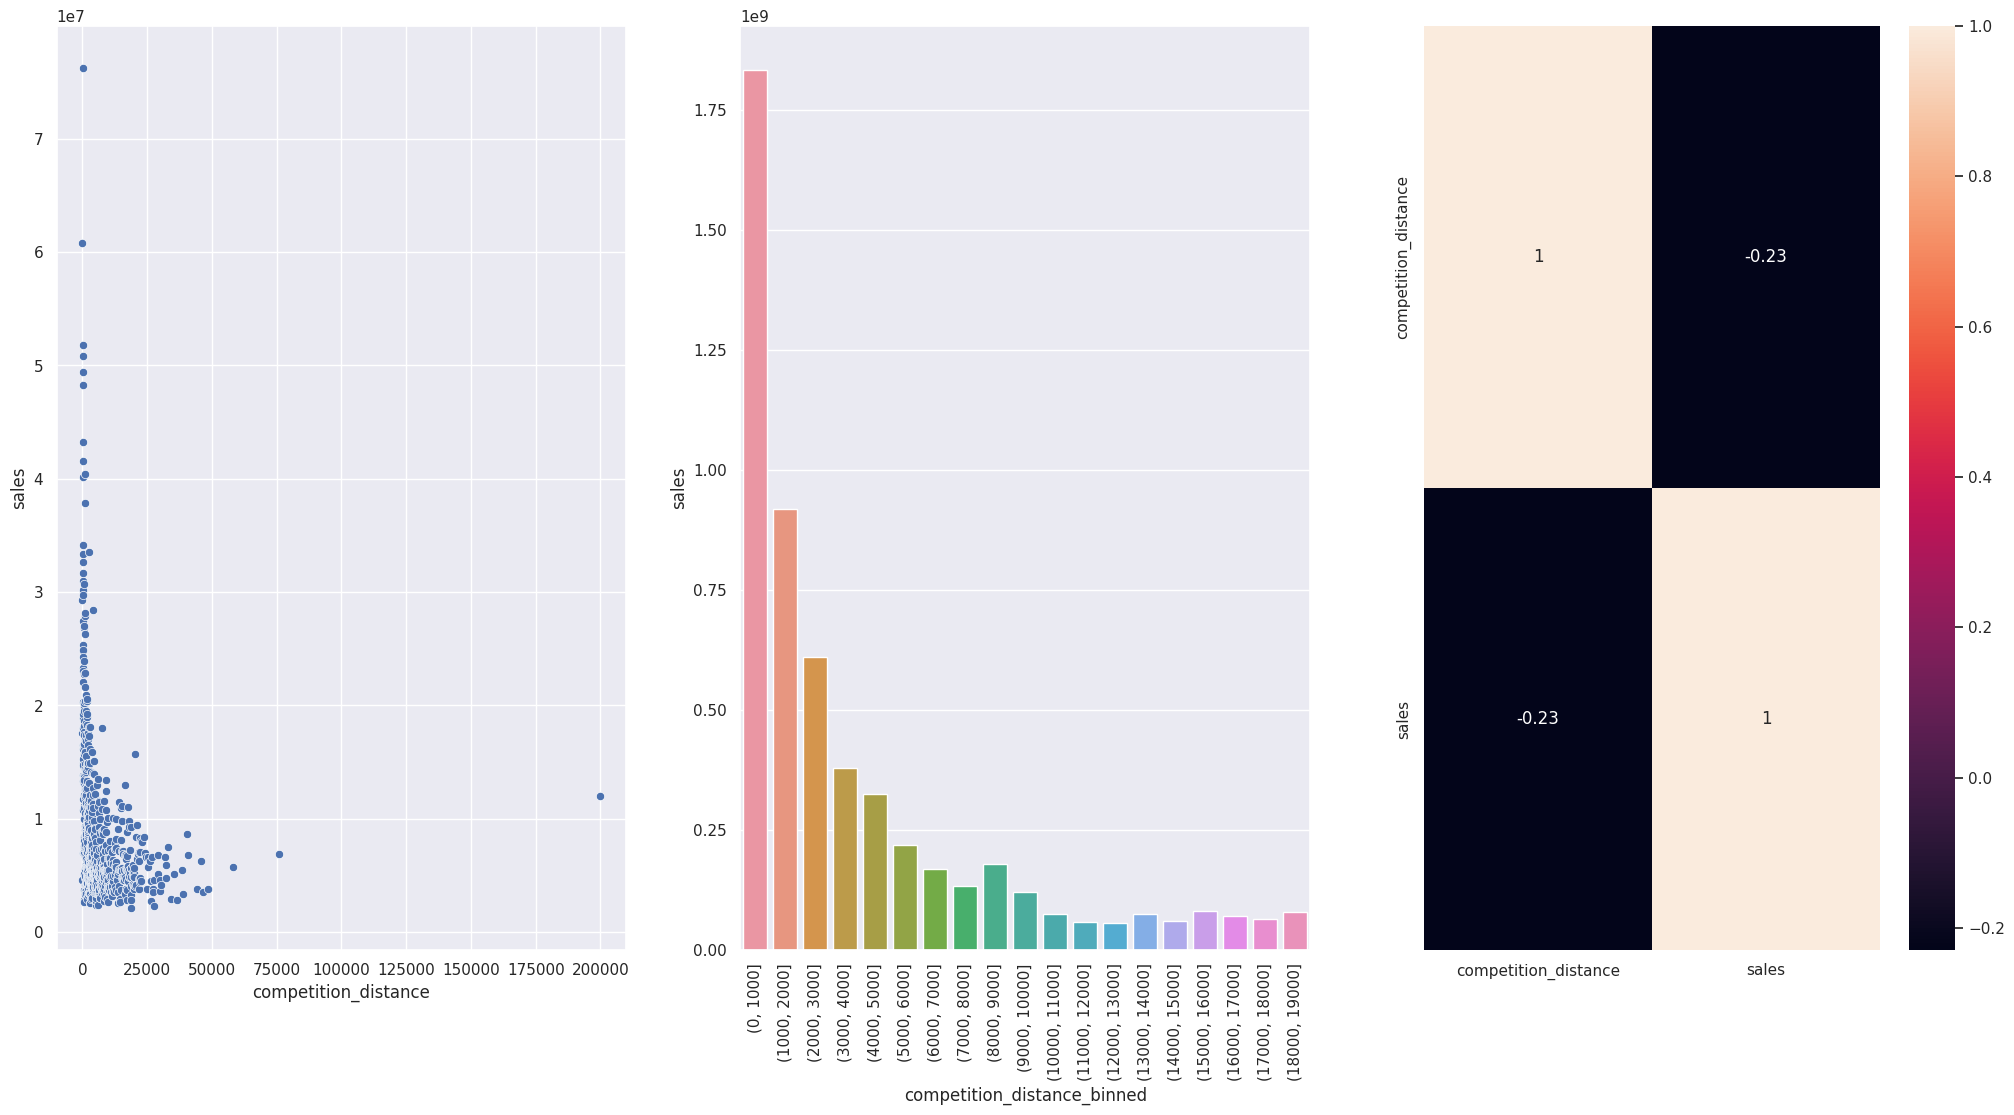

In [37]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

<AxesSubplot: >

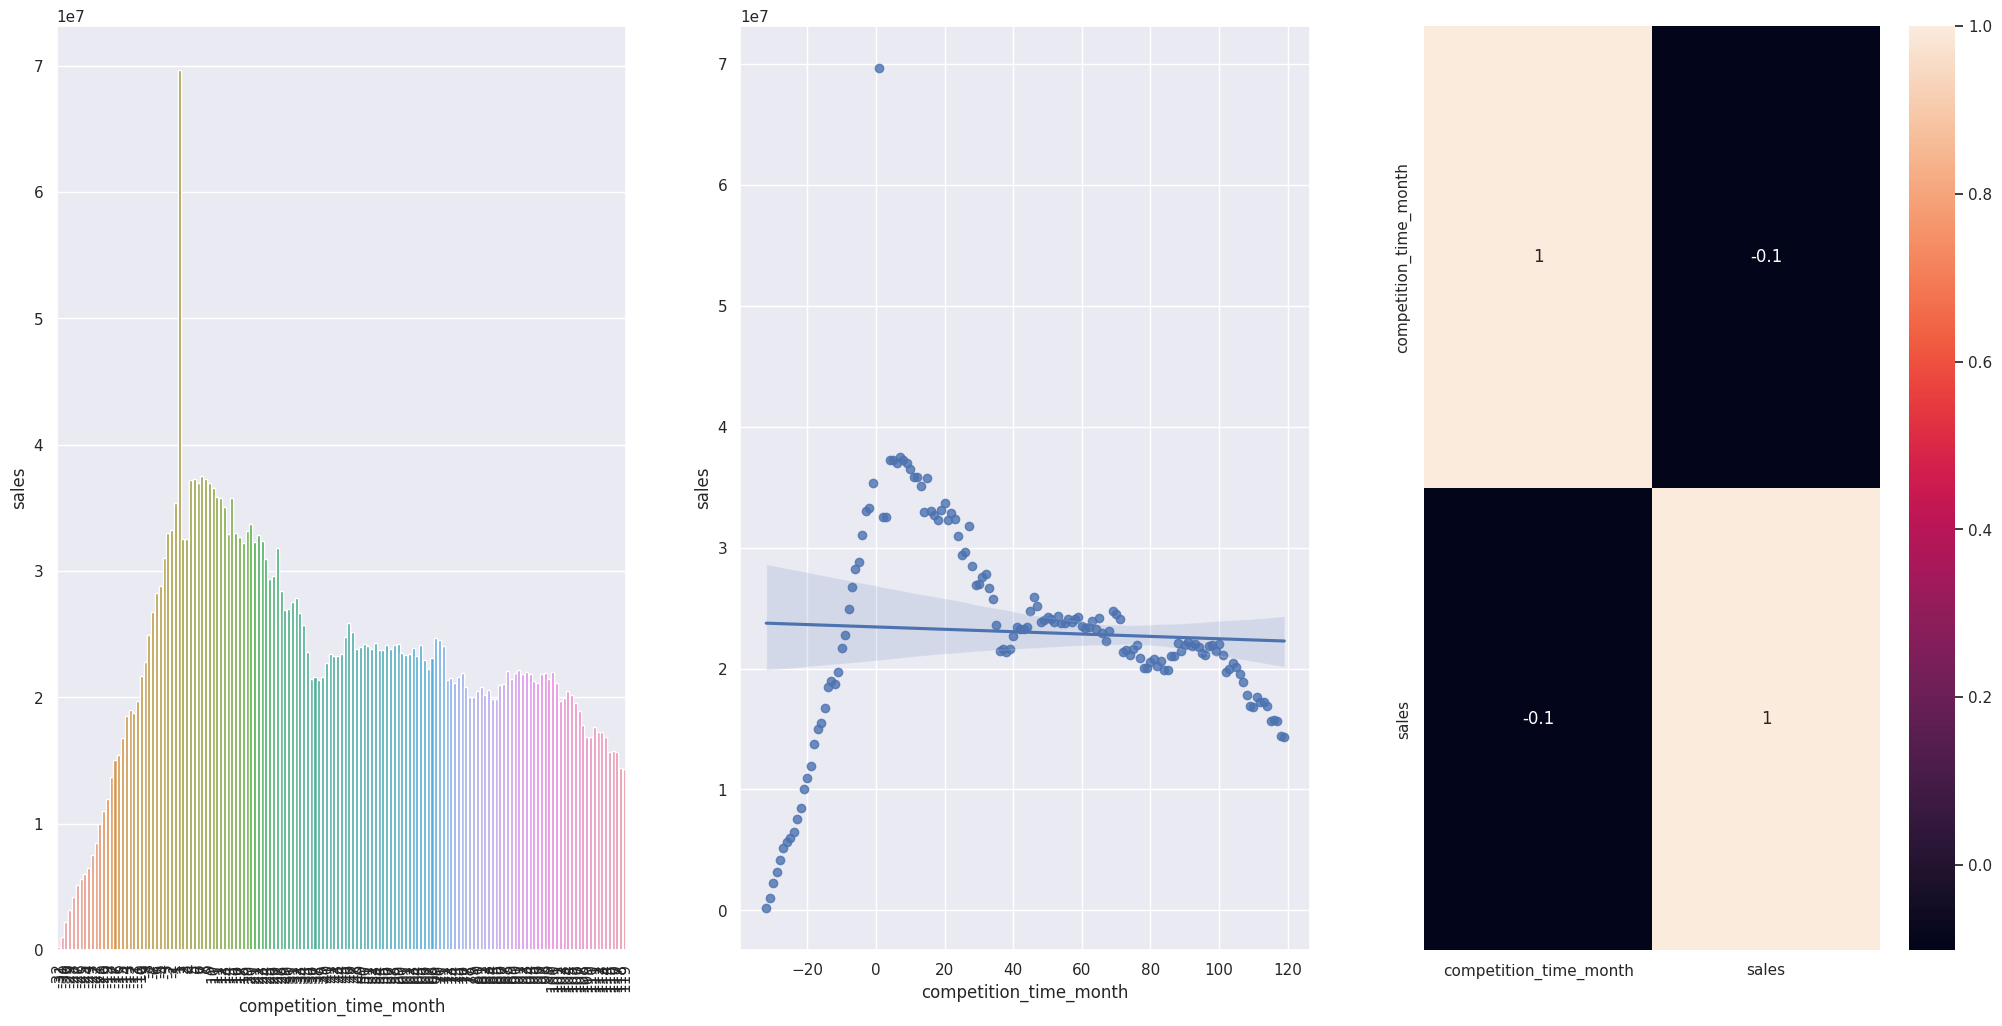

In [38]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO vendem MENOS, depois de um certo período de promoção

<AxesSubplot: >

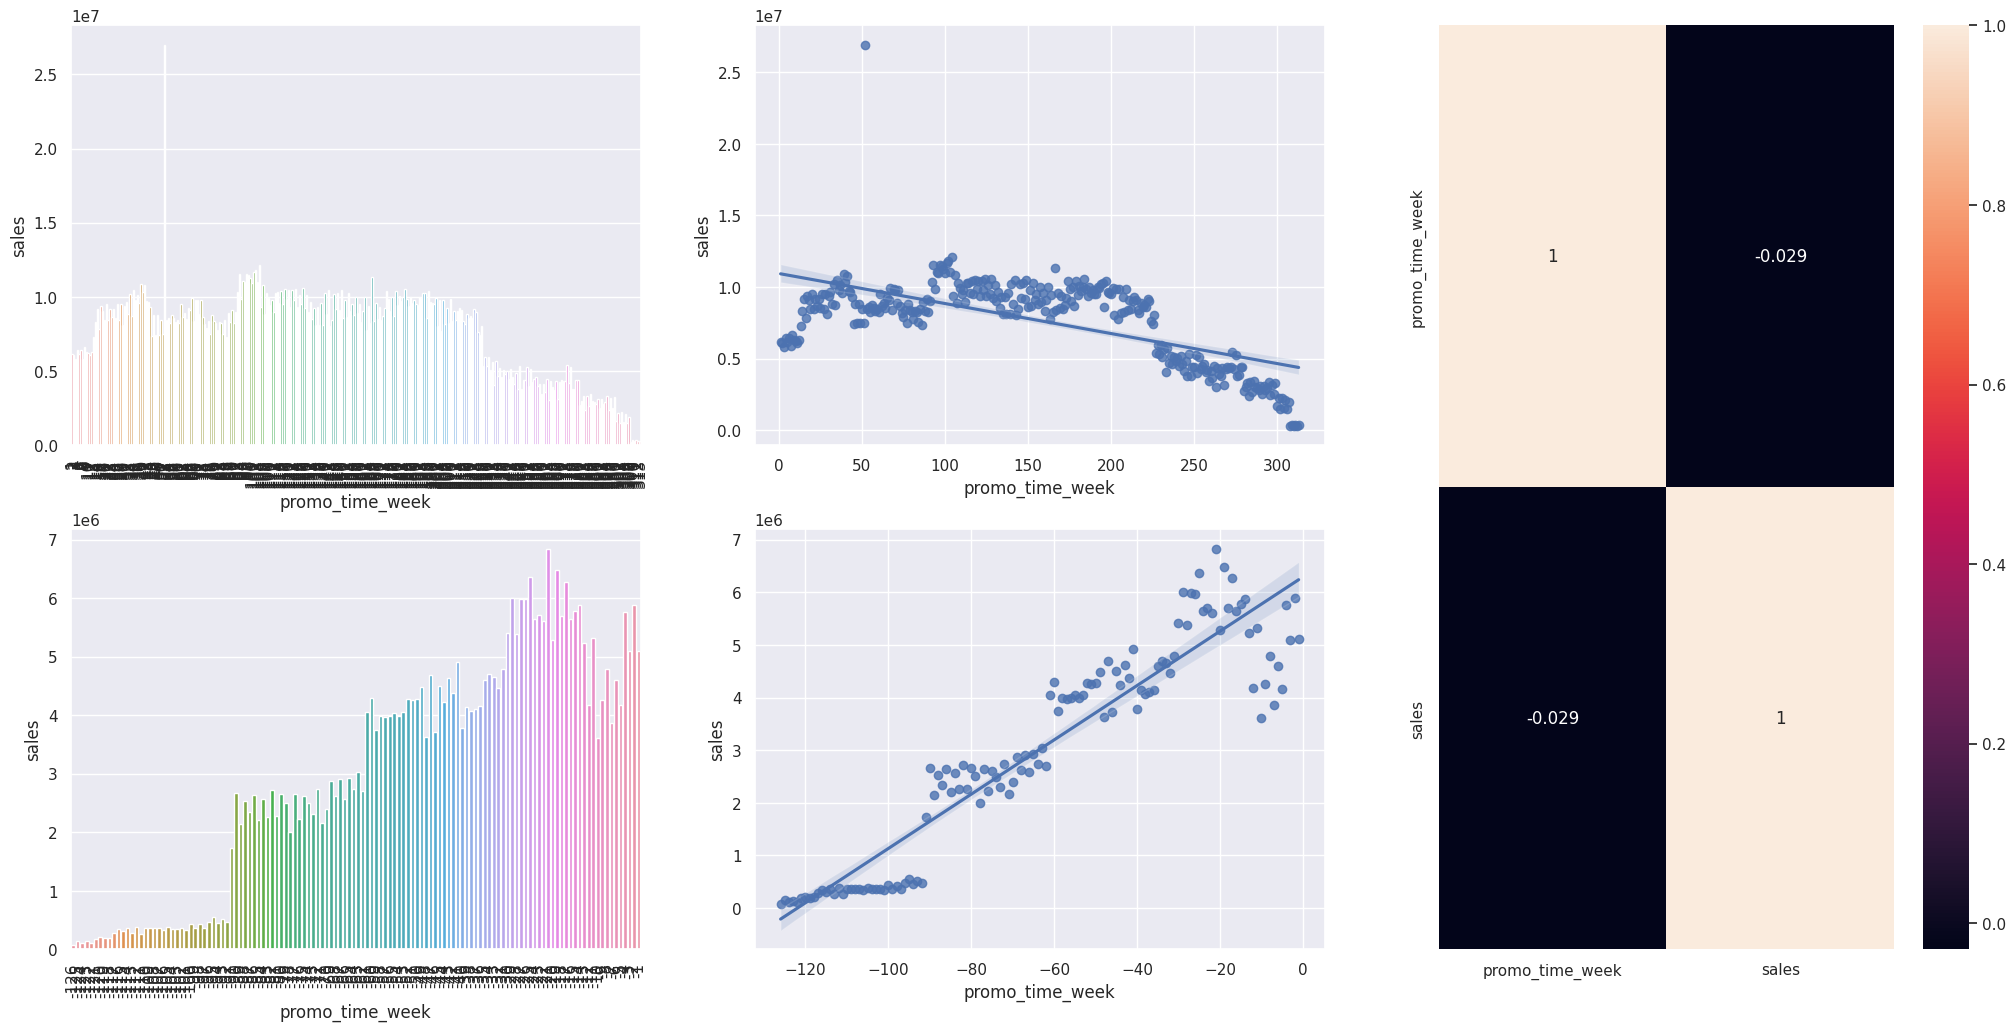

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3= aux1[aux1['promo_time_week'] <0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s>H5.** Lojas com mais dias de promoção deveriam vender mais.<\s>

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE** Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS

In [40]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


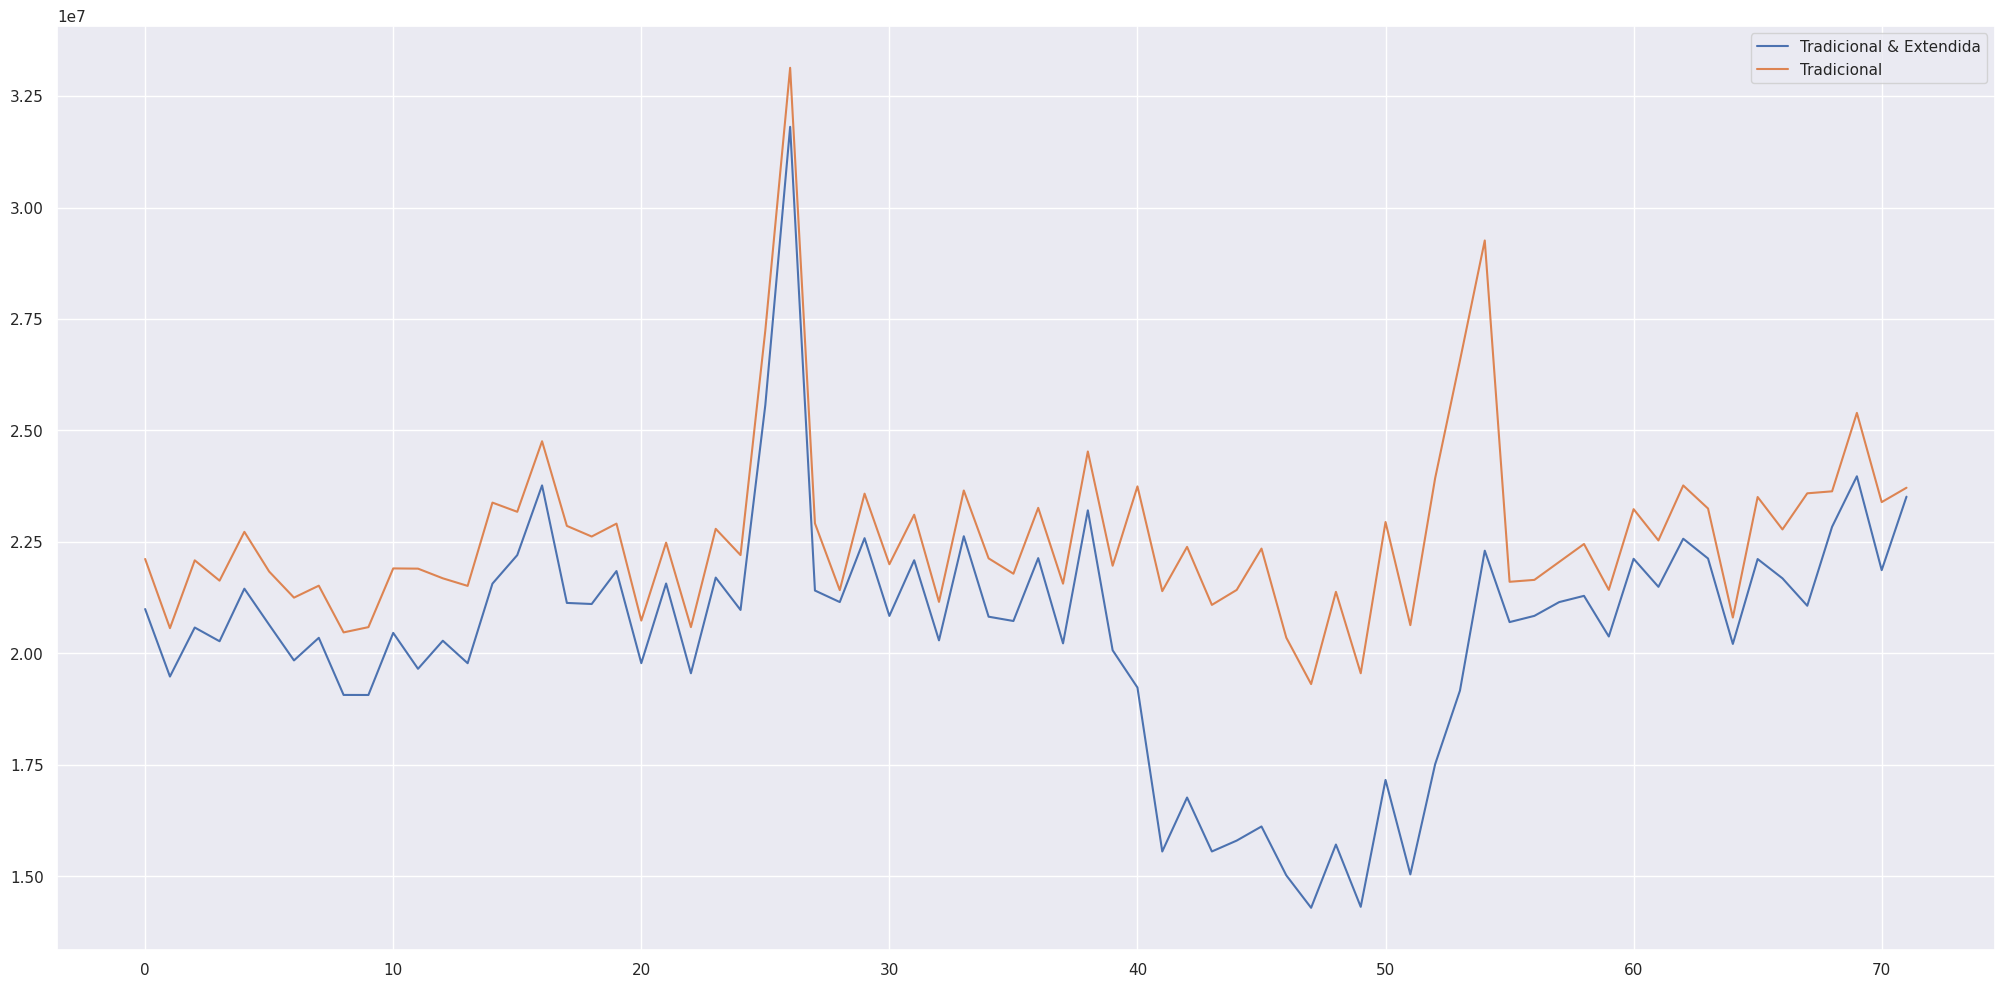

In [41]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida','Tradicional'])

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** Lojas ABERTAS DURANTE O FERIADO DE NATAL vendem MENOS

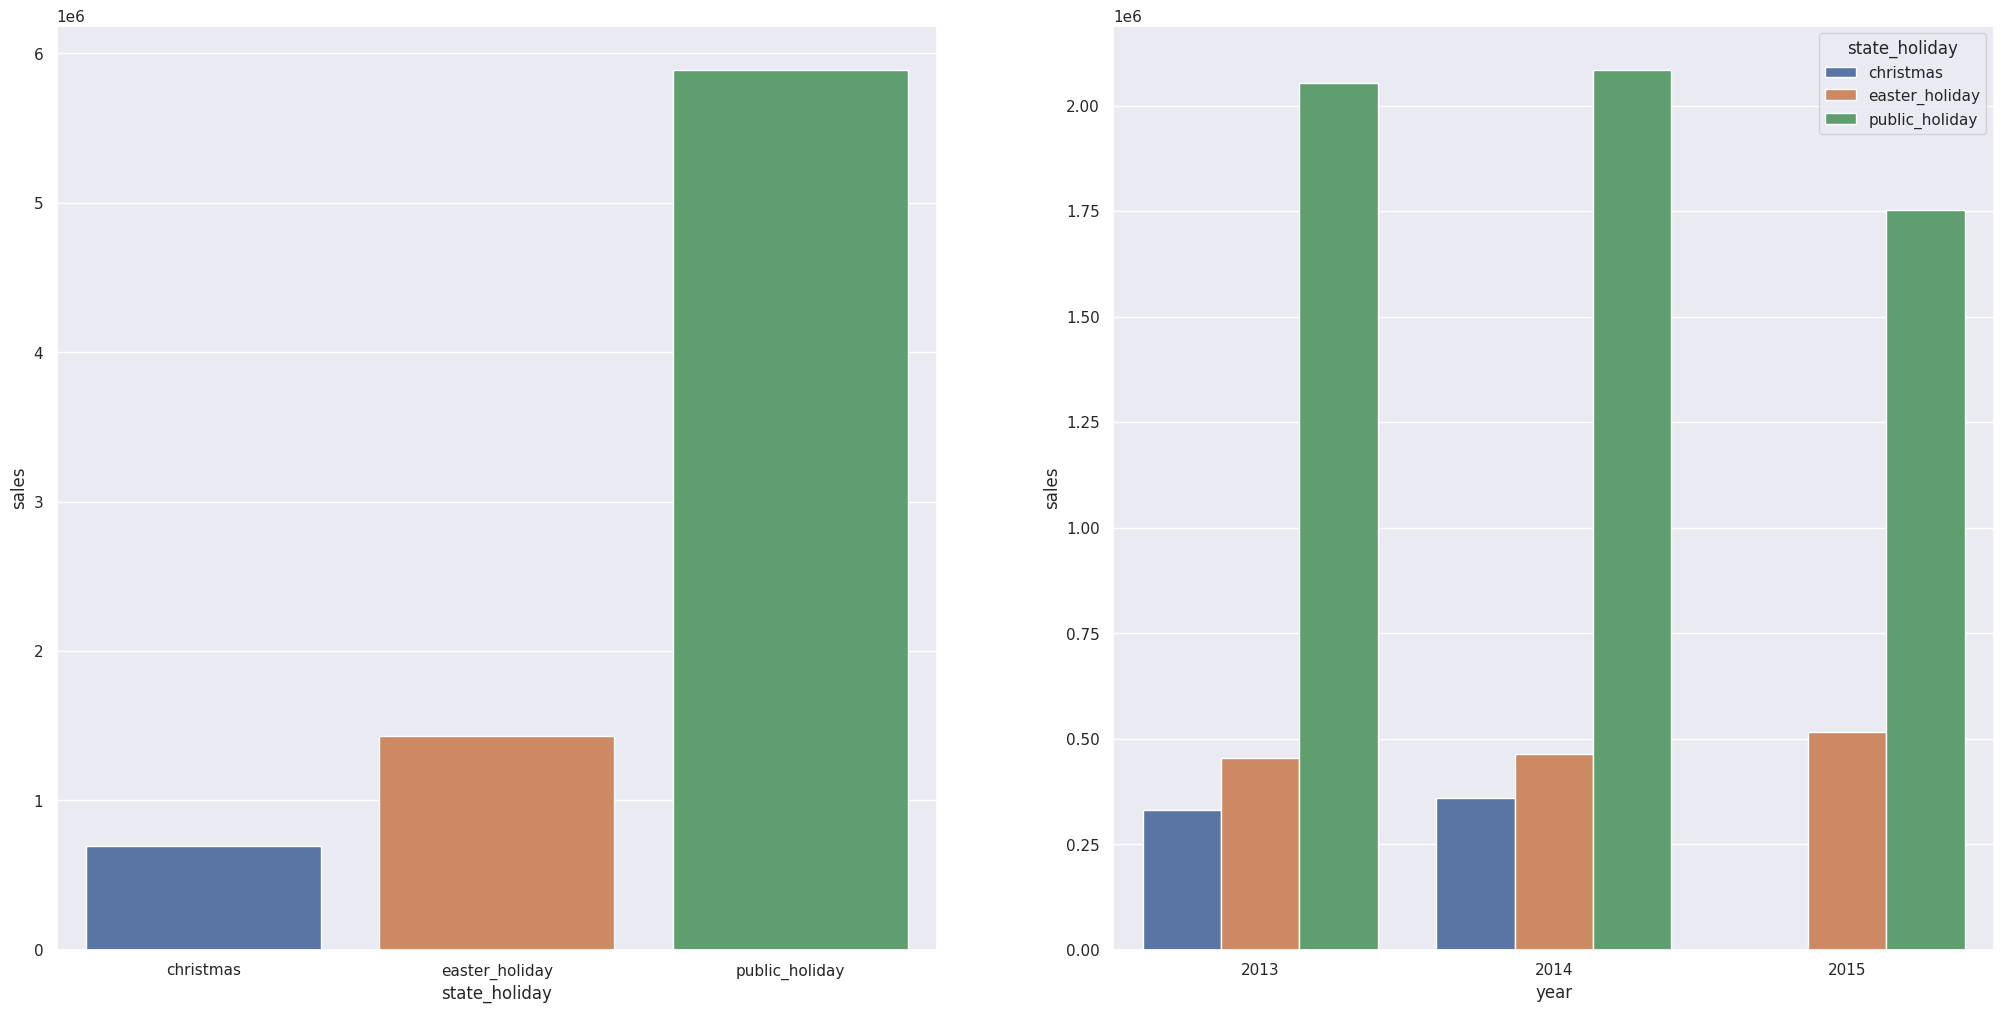

In [42]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSE** Lojas vendem MENOS AO LONGO DO ANO

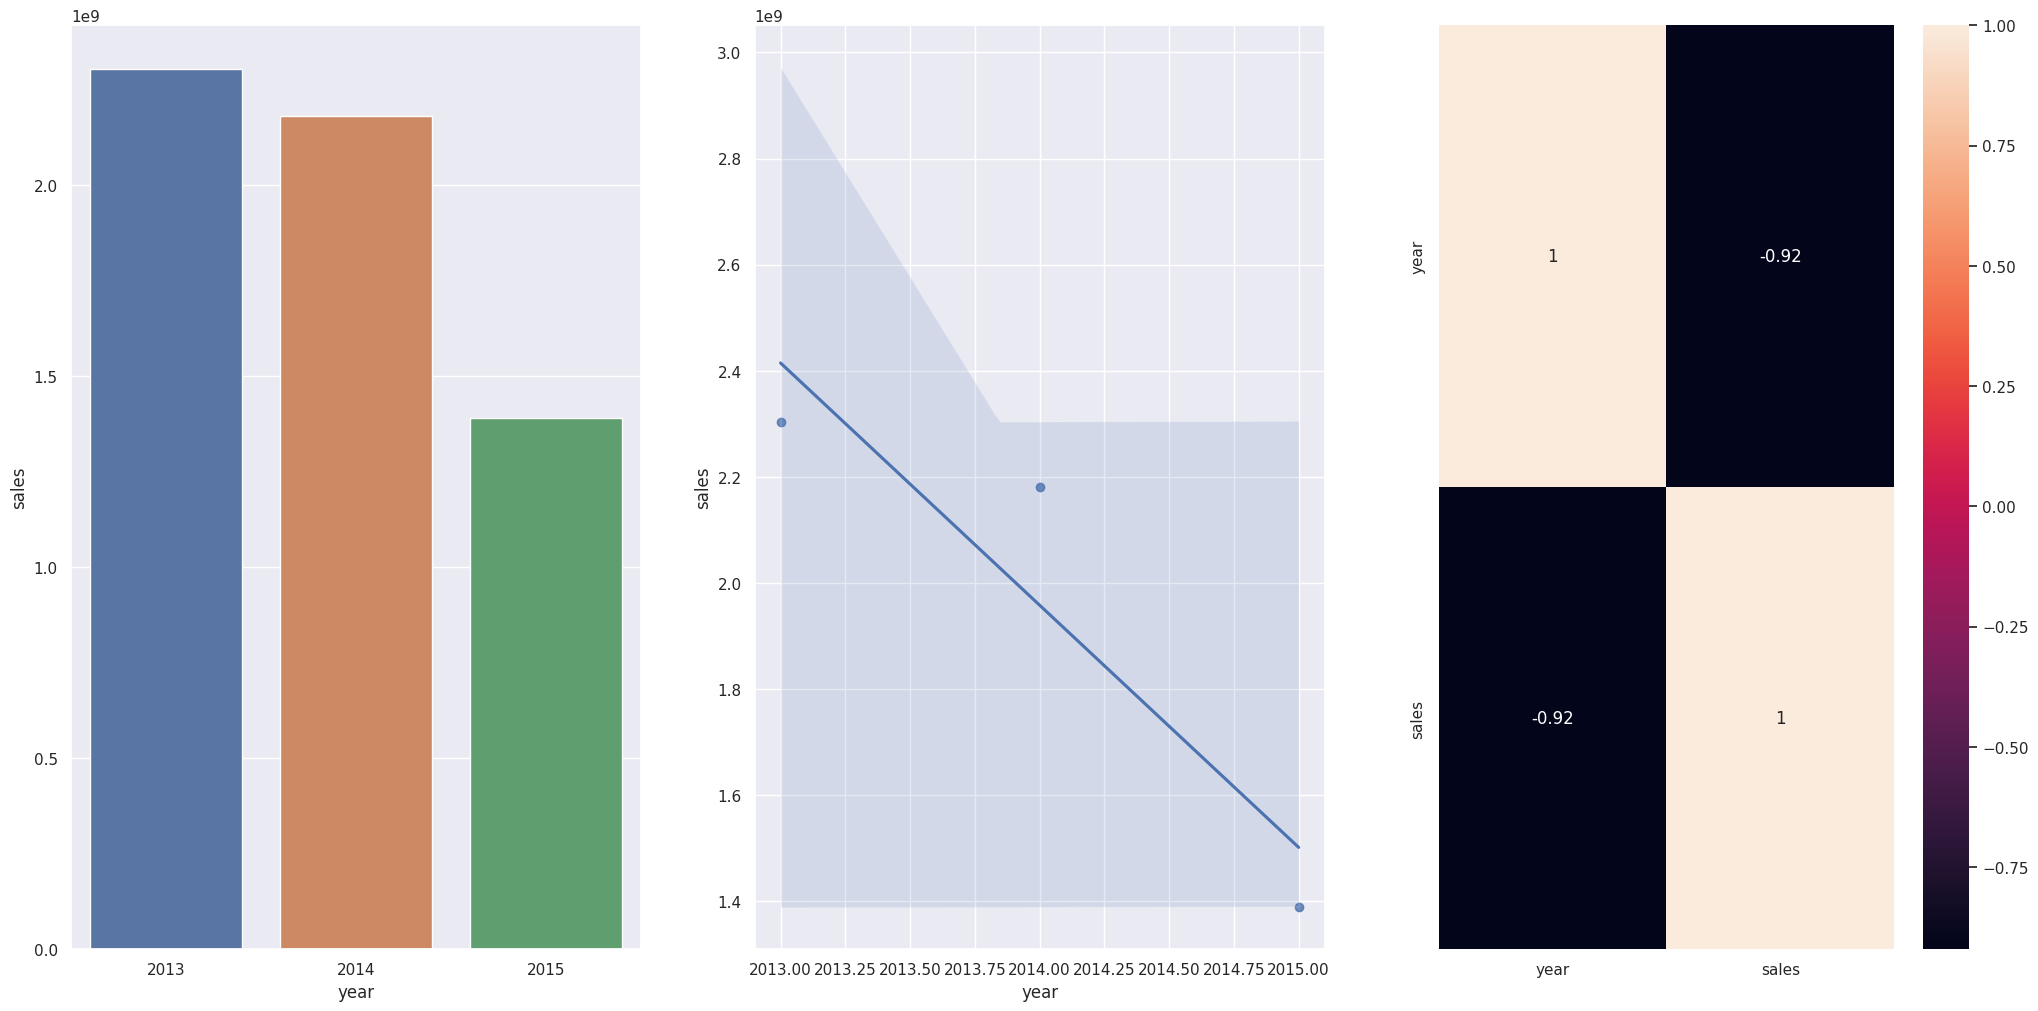

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** Lojas vendem MENOS NO SEGUNDO SEMESTRE DO ANO

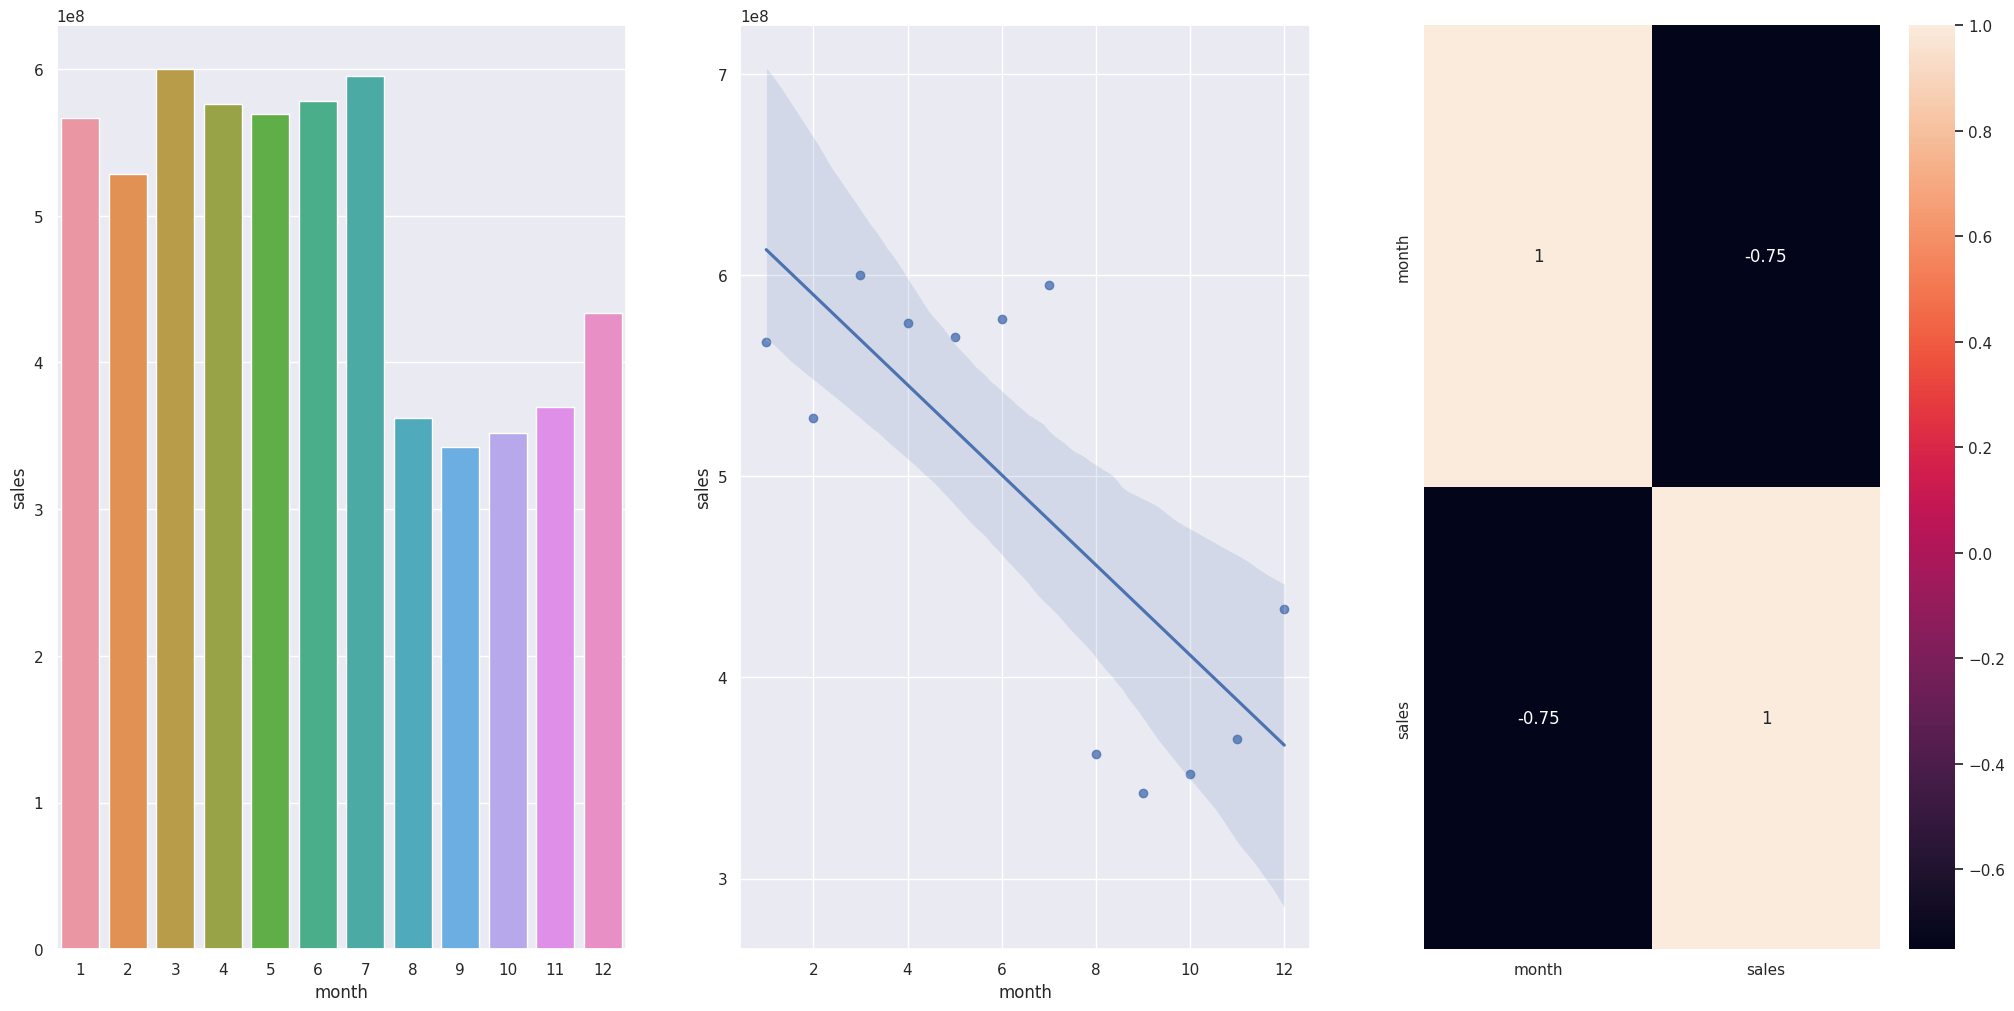

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**TRUE** Lojas vendem MAIS DEPOIS DO DIA 10 DE CADA MÊS

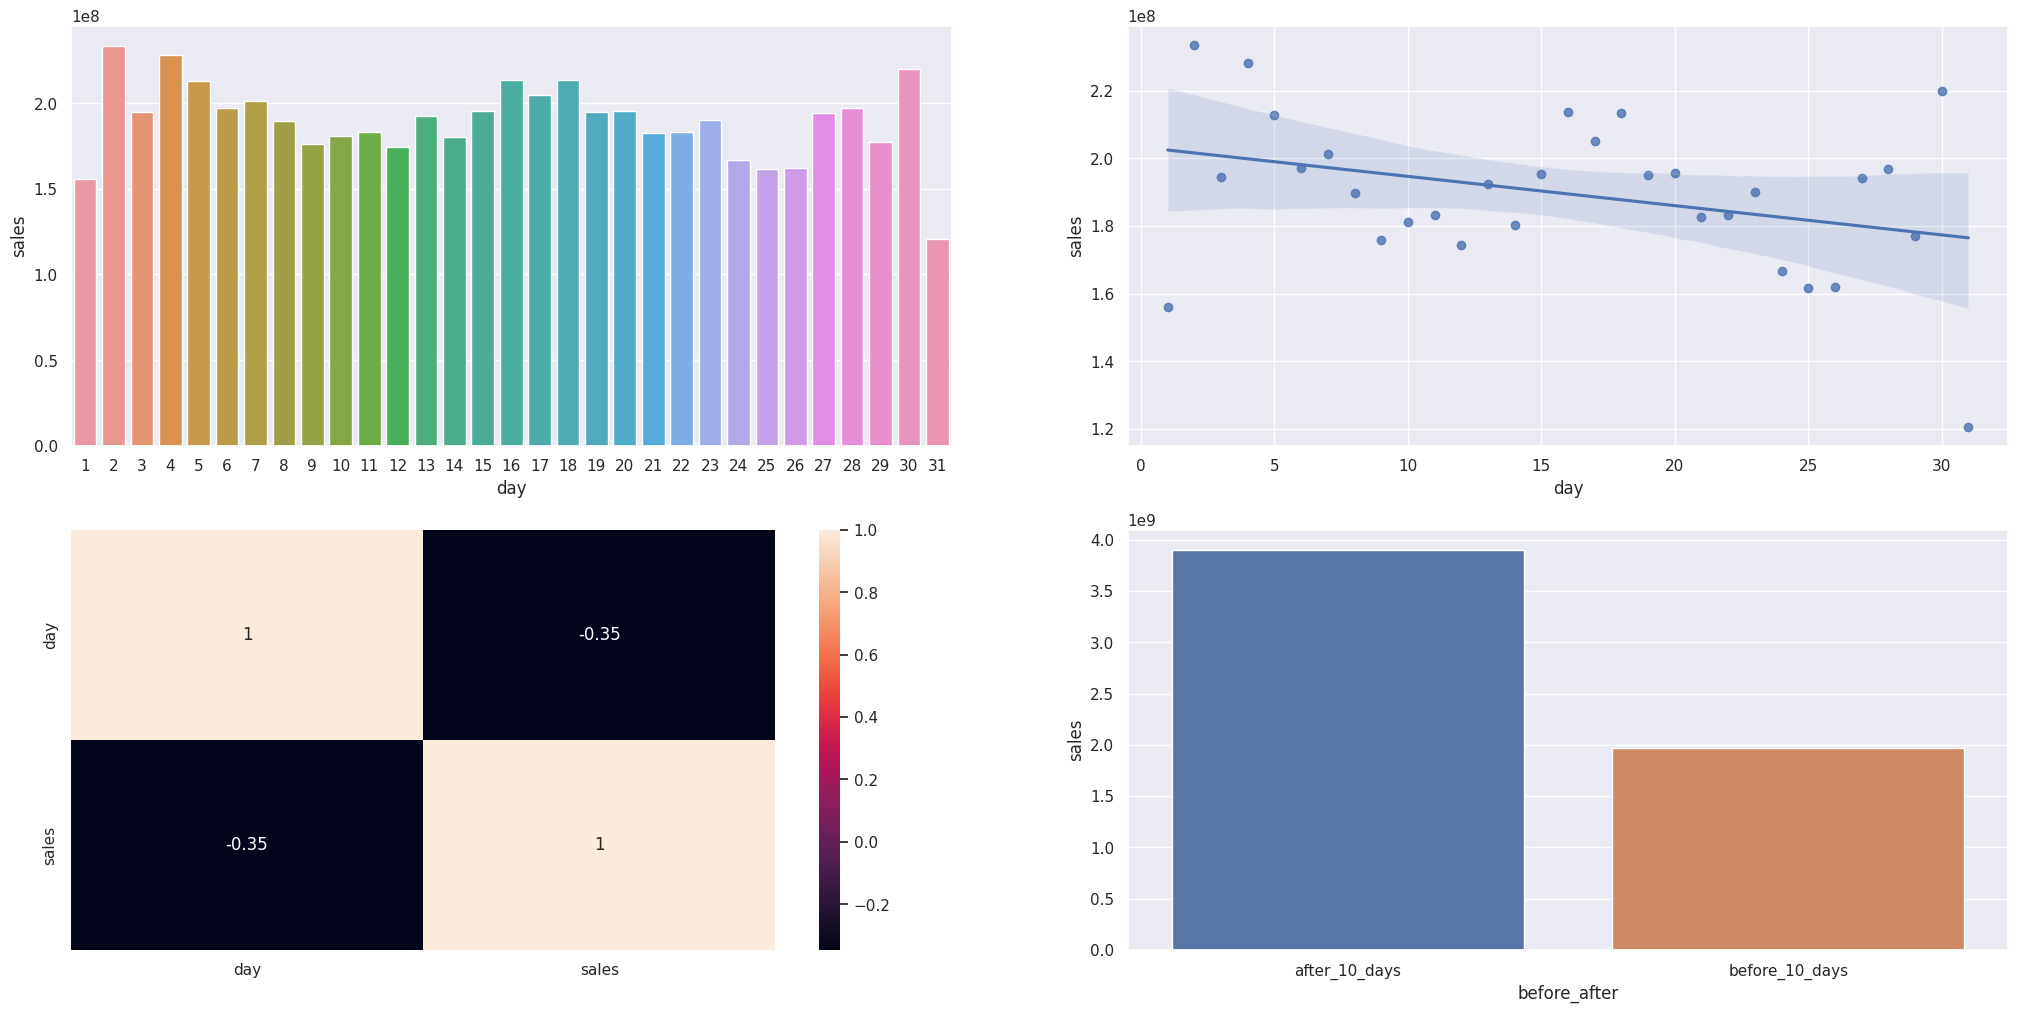

In [45]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H12.** Lojas deveriam vender menos aos finais de semana.
**TRUE** Lojas vendem MENOS AOS FINAIS DE SEMANA

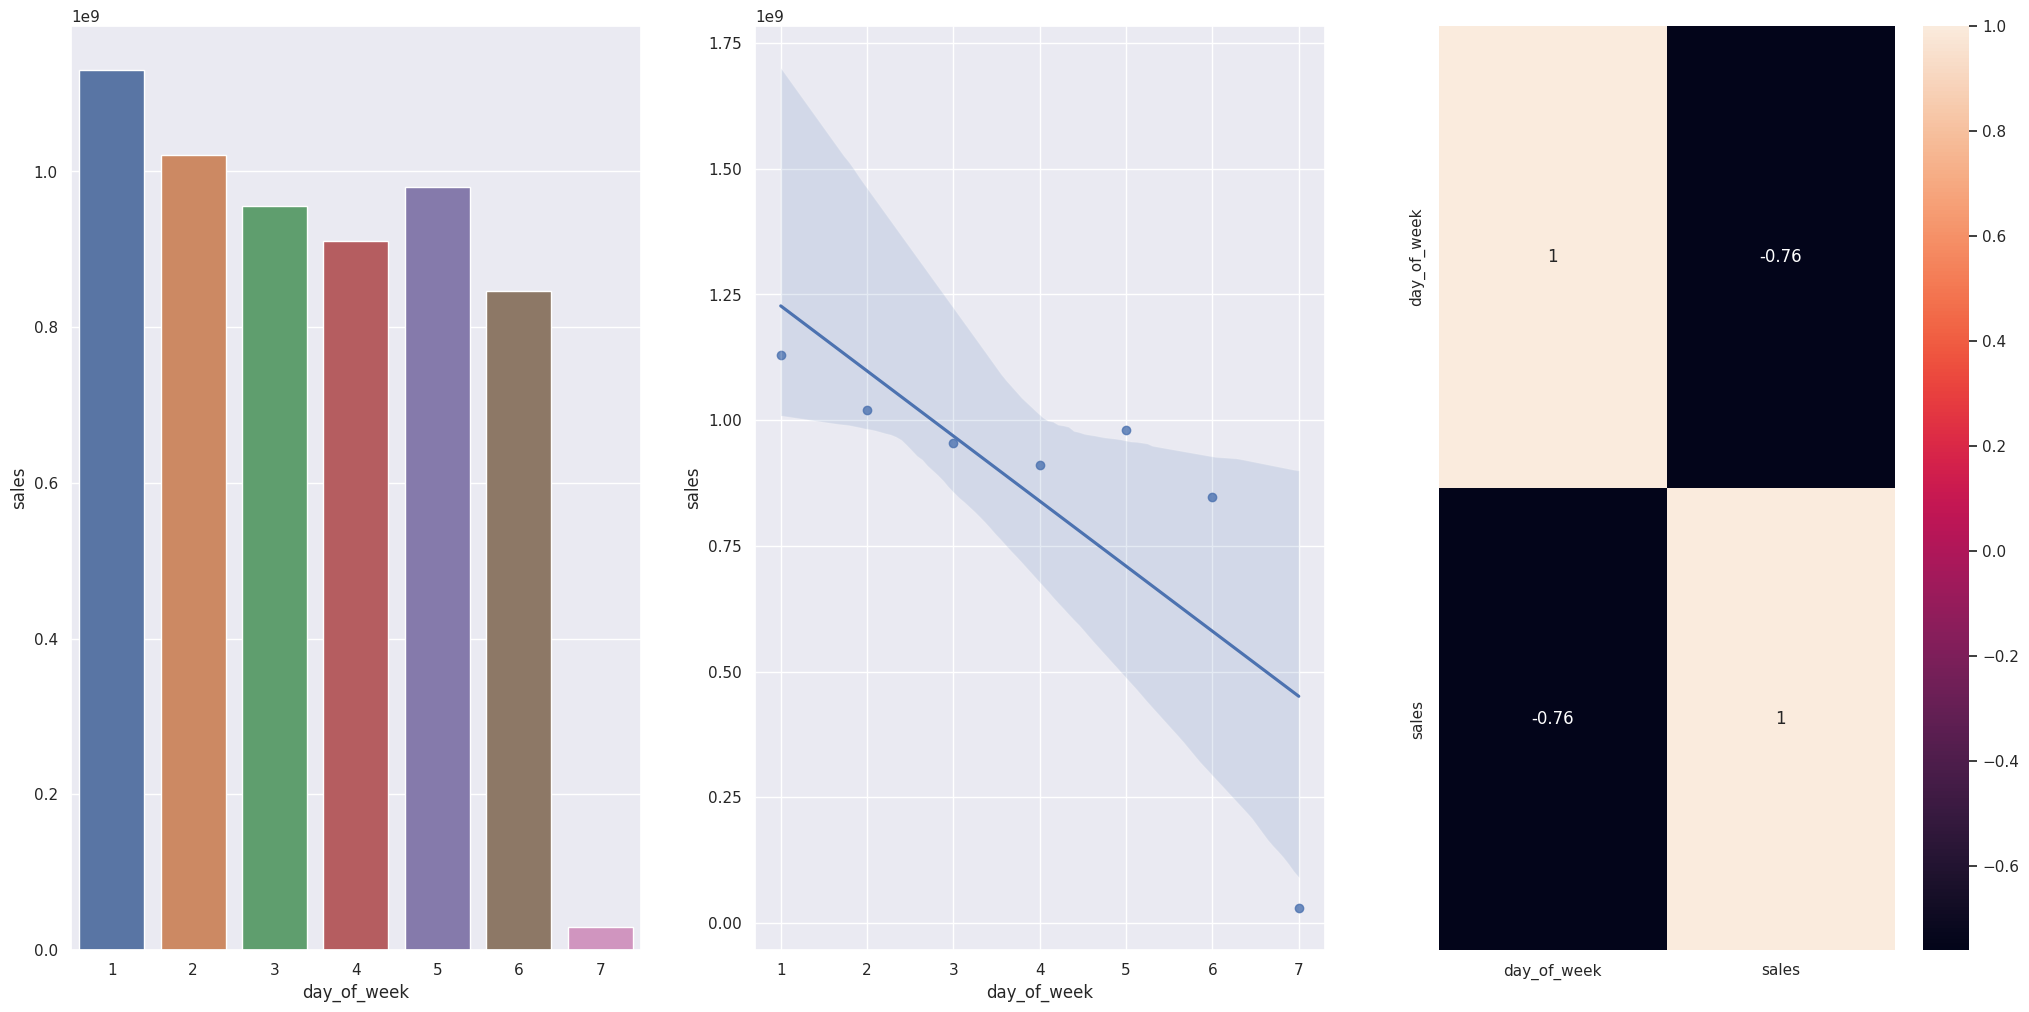

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**TRUE** Lojas vendem MENOS DURANTE OS FERIADOS ESCOLARES, EXCETO OS MESES DE JULHO E AGOSTO

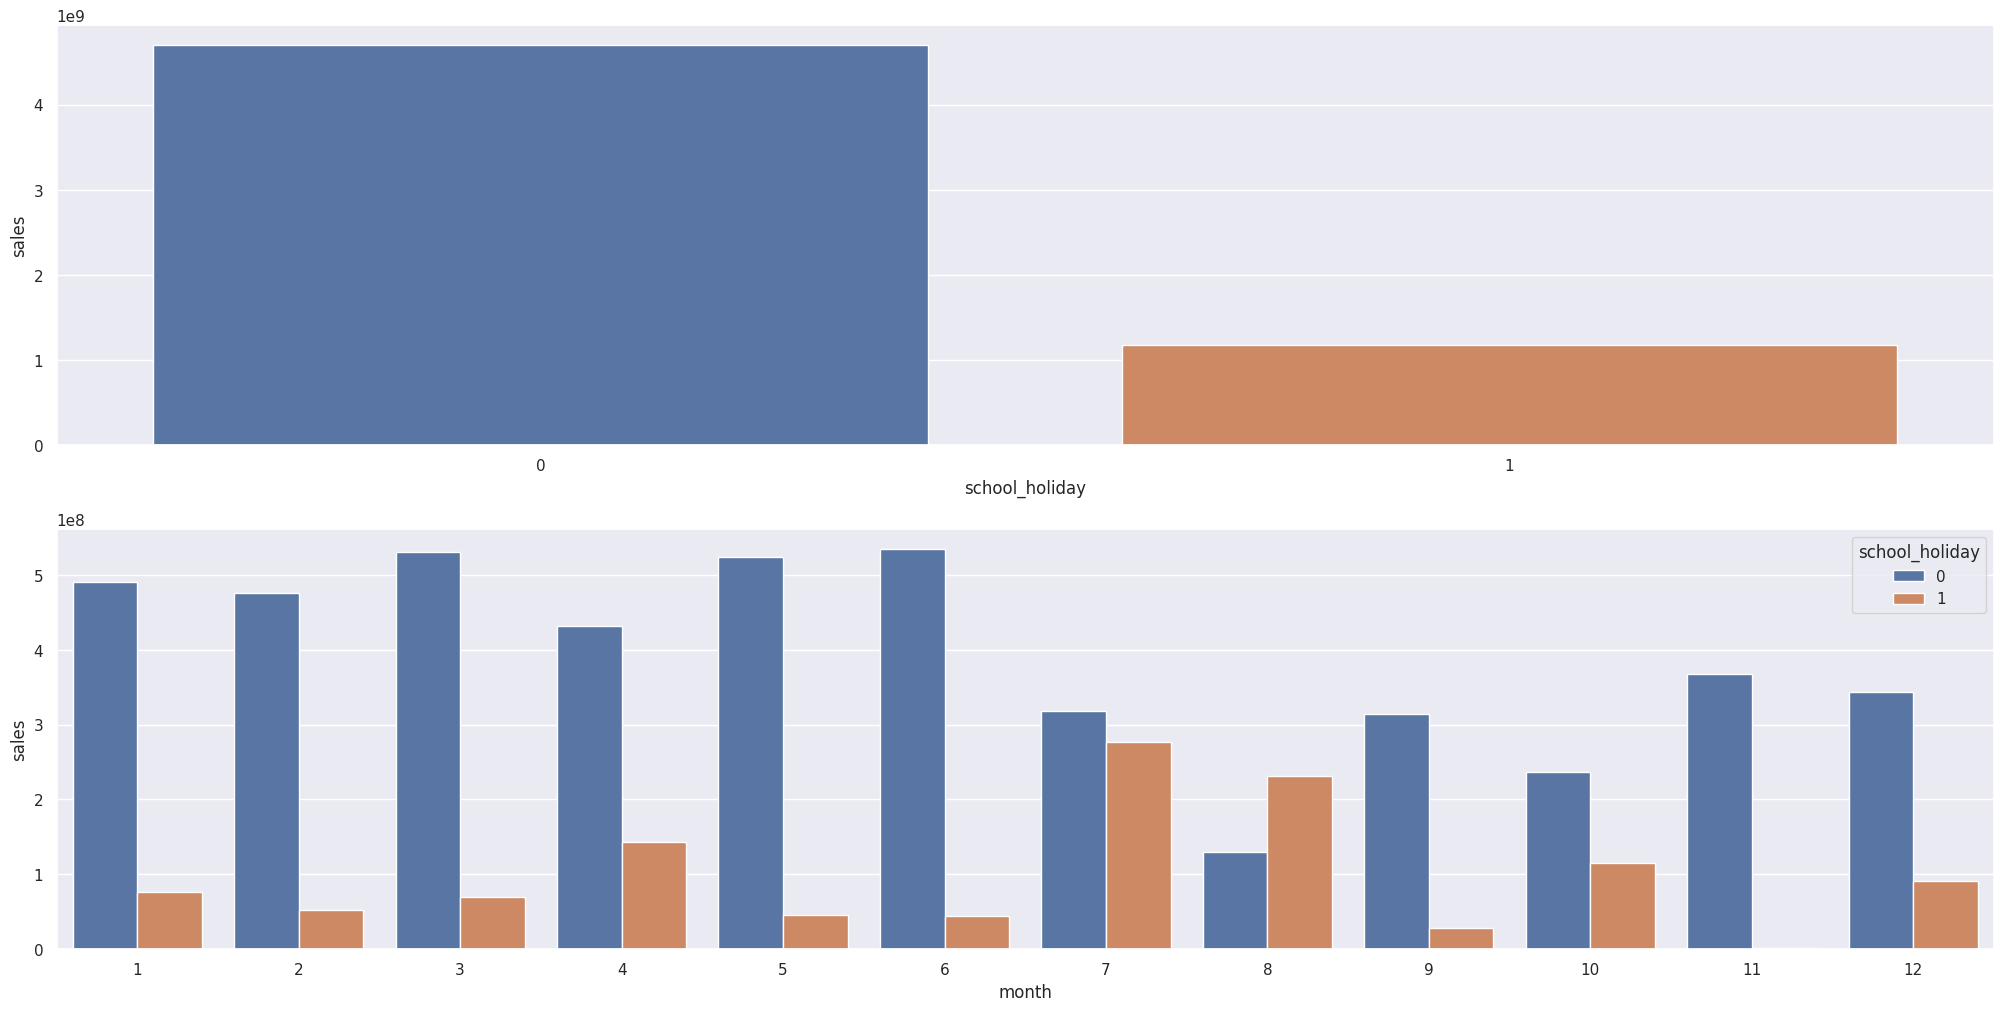

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [48]:
from tabulate import tabulate

In [49]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot: >

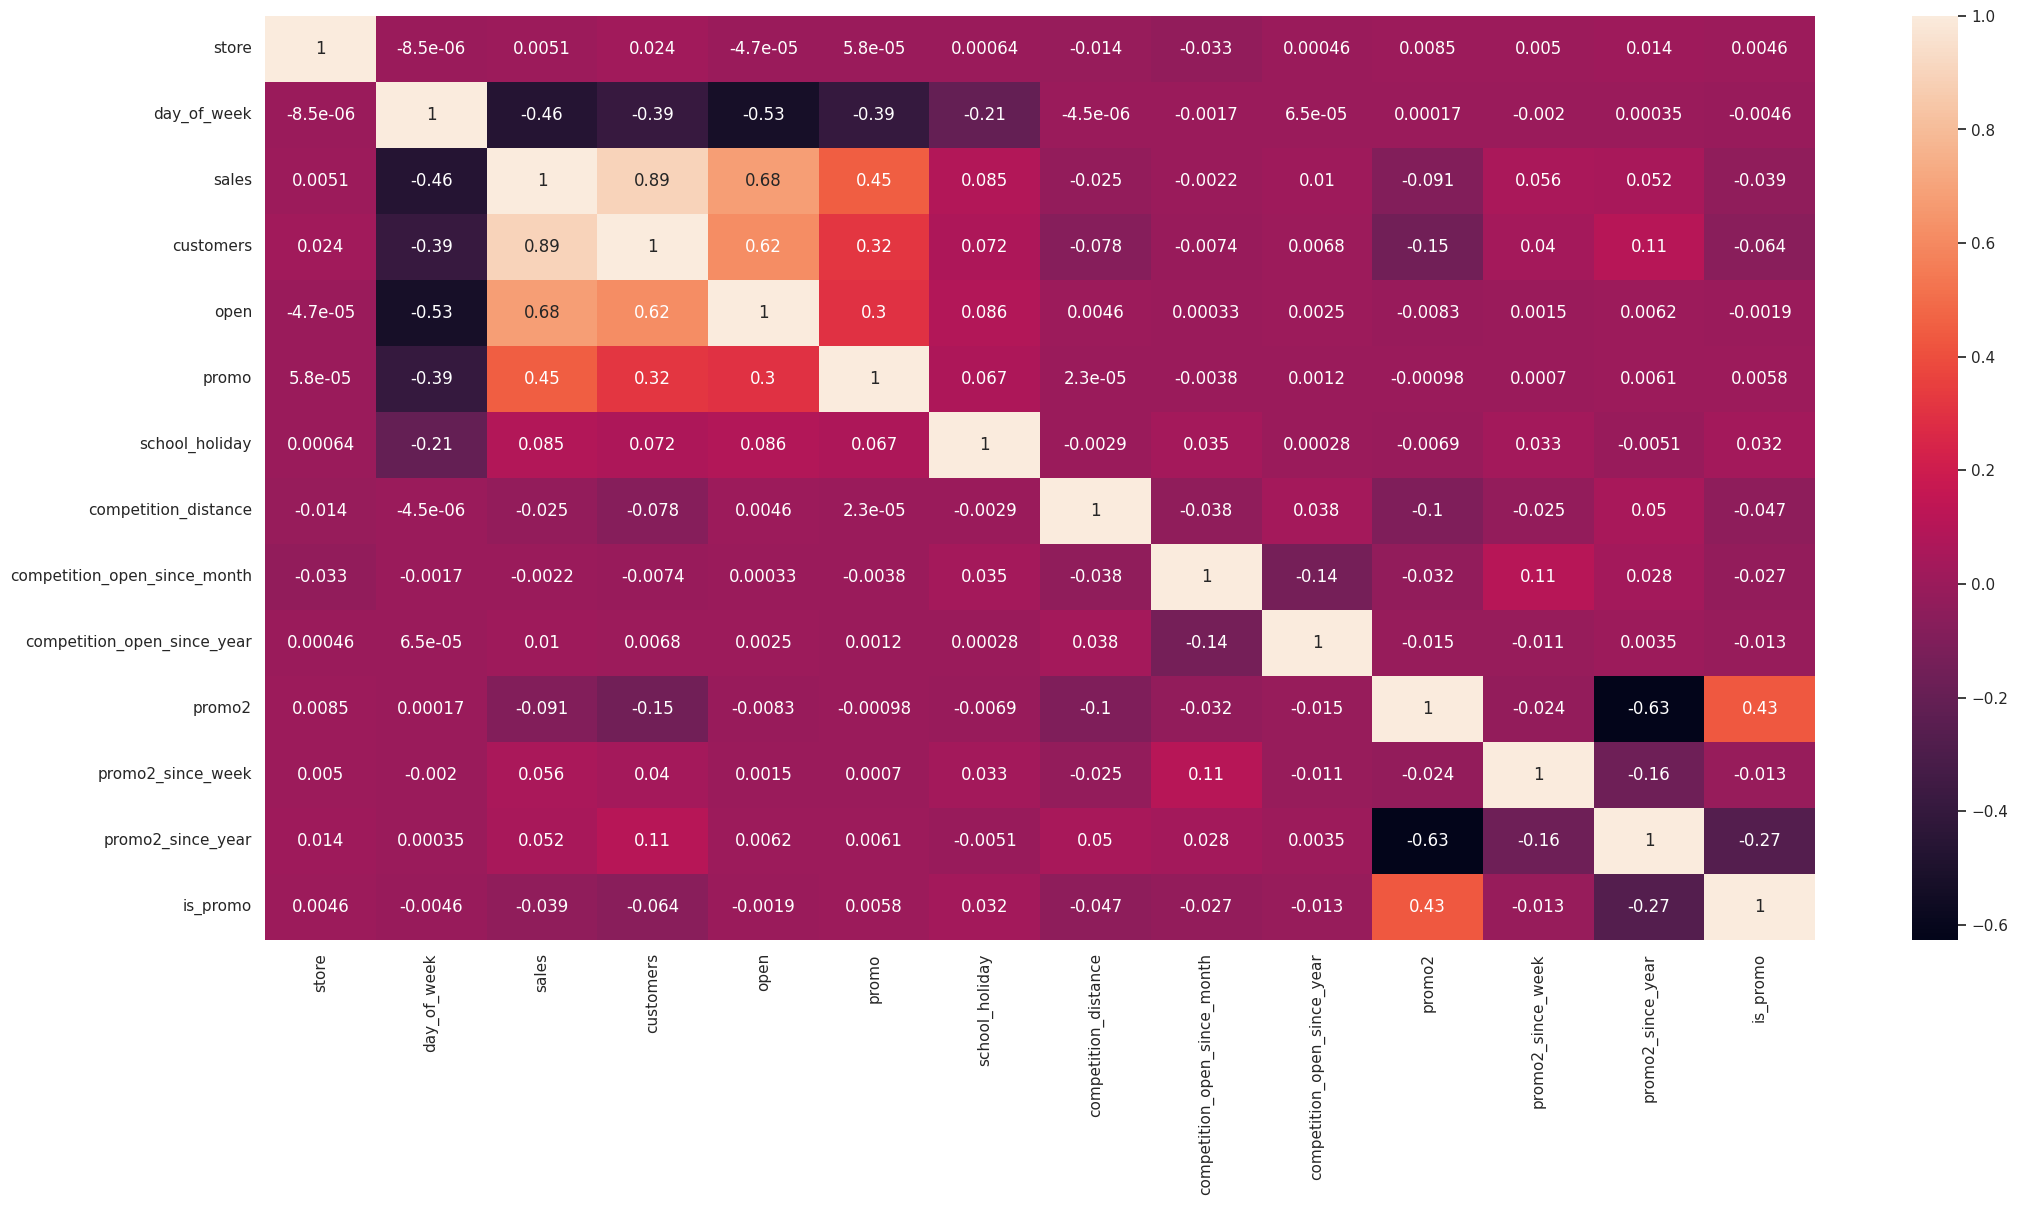

In [50]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot= True)

### 4.3.2 Categorical Attributes

<AxesSubplot: >

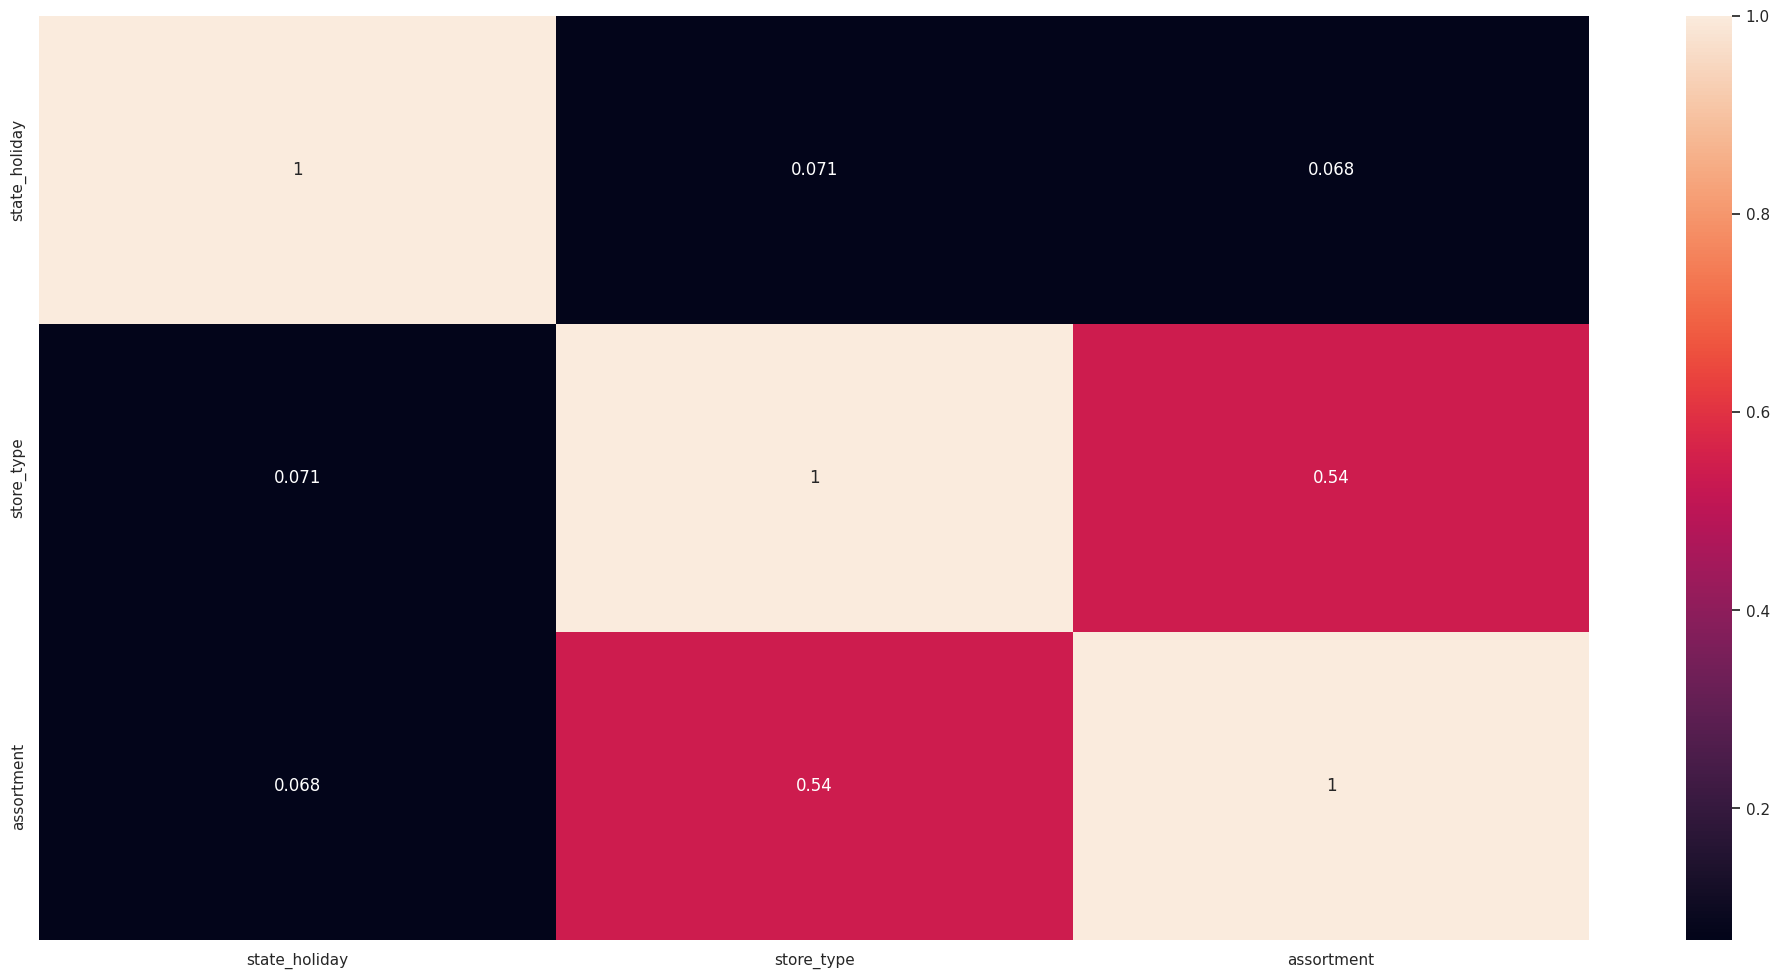

In [51]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 PASSO 05 - DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [53]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

/tmp/ipykernel_2829/22335619.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['competition_distance'])


<AxesSubplot: xlabel='competition_distance', ylabel='Density'>

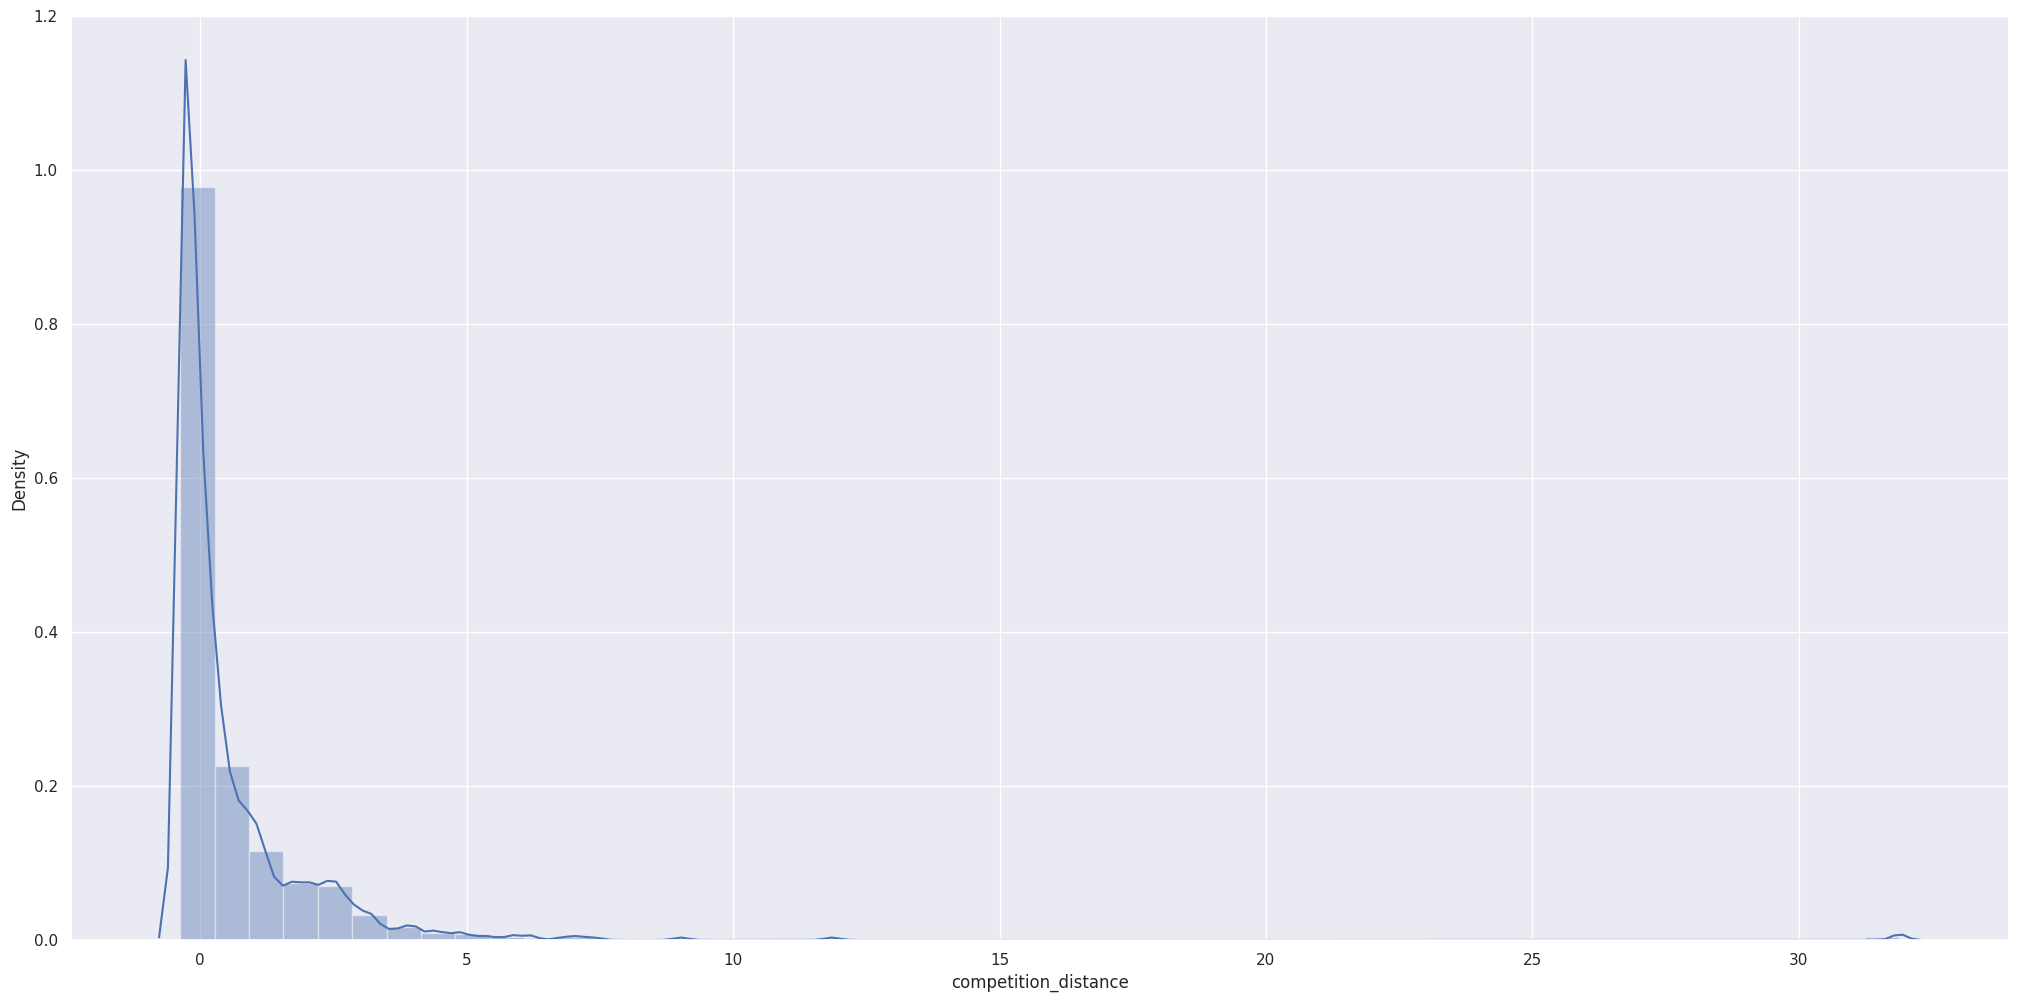

In [54]:
# Exemplo após o reascaling:
sns.distplot(df5['competition_distance'])

## 5.3 Transformação

### 5.3.1 Encoding

In [55]:
df5['assortment'].drop_duplicates()

0       basic
3      extend
258     extra
Name: assortment, dtype: object

In [56]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extend': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [57]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [58]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 6.0 PASSO 06 - FEATURE SELECTION

In [59]:
df6 = df5.copy();

## 6.1 Split dataframe into training and test dataset

In [60]:
cols_drop = ['week_of_year','day', 'month', 'day_of_week', 'promo_since', 'competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [61]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7)

Timestamp('2015-06-19 00:00:00')

In [62]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'. format( X_train['date'].min()))
print('Training Max Date: {}'. format( X_train['date'].max()))

print('\nTest Min Date: {}'. format( X_test['date'].min()))
print('Test Max Date: {}'. format( X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [63]:
# training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

In [63]:
# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy(estimator=RandomForestRegressor(n_estimators=73, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FEF4F1E0340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FEF4F1E0340, verbose=2)

### 6.2.1 Best Features from Boruta

In [67]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# no selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [73]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 PASSO 07 - MACHINE LEARNING MODELLING

In [106]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [66]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result                           

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [67]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [109]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAR CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [68]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [110]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAR CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [69]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738


### 7.4.1 Random Forest Regressor - Cross Validation

In [112]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAR CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28


## 7.5 XGBoost Regressor

In [70]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.8,
                             colsample_bytree=0.8
                             ).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.861238,0.949519,7331.089157


### 7.5.1 XGBoost Regressor - Cross Validation

In [111]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAR CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.5 +/- 588.71,0.95 +/- 0.0,7715.64 +/- 689.36


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [71]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.080548,0.099879,1010.101738
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.861238,0.949519,7331.089157


### 7.6.2 Real Performance - Cross Validation

In [115]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAR CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.7 +/- 219.24,0.12 +/- 0.02,1256.59 +/- 320.28
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7049.5 +/- 588.71,0.95 +/- 0.0,7715.64 +/- 689.36


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [124]:
import random
import warnings
warnings.filterwarnings('ignore')

In [140]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 2

In [ ]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}


## 8.2 Final Model

In [129]:
param_tuned = {'n_estimators': ,
               'eta': ,
               'max_depth': ,
               'subsample': ,
               'colsample_bytree': ,
               'min_child_weight': 
              }
MAX_EVAL = 2

In [70]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']
                                  ).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.861238,0.949519,7331.089157
